
# 1. Introduction

This notebook has been developed for the purposes of the EMPIR project “Metrology for the Factory of the Future” (Met4FoF) -  Activity A1.2.2 of the Work Package 1.Two laboratories in PTB and CEM posses conventional dynamic calibration set-ups for acceleration sensors under test. The objective was to extend current calibration systems for digital-output sensors.  The objective of the task is to compare measurement results of the two laboratories, PTB and CEM, provided by the extended dynamic calibration systems. 

## 1.1. State of the art

In conventional dynamic calibration procedures for acceleration sensors, the acceleration used for the sensor input is applied either as **a sinusoidal excitation with a given frequency and amplitude** or as **a singular shock-like excitation characterized by pulse width and intensity**. 
<br>The quantity is then measured by a reference sensor and by the device under test (DUT). The results of DUT are compared to the reference and hence characterized and linked to the SI. In a dynamic calibration situation, the response of the DUT to time-varying input is the major interest. Hence, it is crucial that the mechanical input operates simultaneously and equally on the reference and DUT. Both, the reference and the DUT provide **electrical outputs (typical voltage)** while **the data acquisition electronics** of the system provides **the analogue to digital conversion (ADC).**
In order to connect the reference and the DUT to the ADC system, two analogue channels are needed. In order to get reliable information on the time dependent response, the timing of the data acquisition on the two channels has to be synchronized. This is typically accomplished by provision of a common clock signal to drive the sampling units of the ADC and a common trigger to start (or mark) the beginning of the acquisition. 

## 1.2. The extension of conventional dynamic calibration systems to digital-output sensors 

In a set-up where the DUT is a digital-output sensor,the sampling of the DUT time series is no longer under the control (trigger, clock) of the calibration system. Instead, the DUT comprises its own digitizer unit with a time base independent of the calibration system. In fact, a typical conventional calibration set-up does not provide an input for digital data at all.
The solution to this problem requires two extensions:
1.	A digital acquisition unit (DAU) which is capable to connect to the digital interface of the sensor under calibration and store/transmit the DUT time-series for later analysis
2.	An additional synchronization signal that provides the link between the time-base of the calibration system and the time-base of the DUT.

The concept for the extension of existing facilities for dynamic calibration uses a custom digital acquisition unit microcontroller board with a connected reference time signal for traceable time stamping of acquired data points. This allows for a synchronised data acquisition from the reference measurement and the DUT. The selected sensor for acceleration measurements is a three axial low-g acceleration sensor with digital output, which allows measurements of acceleration in three perpendicular axes.**At the moment and in this notebook, only an X-axis acceleration has been observed.** 
    
The selected laboratories posses their set-ups and the calibration items were calibrated in both set-ups.The analysis required transformation from time domain to the frequency domain, where frequencies and corresponding magnitudes and phases were calculated.The measurement conditions were kept according to the laboratory standard conditions. 

Each laboratory submitted HDFT files containing groups:
- EXPERIMENTS - containing 171 files (experiment) corresponding to the sine excitations
- RAWDATA - where data from ADCs (*voltage, absolute time, absolute time uncertainty*)  and sensors (*absolute time, absolute time uncertainty, acceleration, angular velocity, magnetic flux density and temperature*) can be approached during the measurements
- RAWTRANSFERFUNCTION - *this group contains quantities of interest: frequencies, amplitudes, assigned uncertainties of amplitudes, phases,  assigned uncertainties of phases, excitation amplitudes and assigned uncertainties of excitation amplitudes
- REFERENCEDATA - reference data from ADCs and sensors.

    
| <b>PTB<b> | Sensor | Internal ADC |
| --- | --- | --- |
| <b>Name<b> | MPU 9250| STM 32 Internal ADC |
| <b>ID<b>  | 535035904 | 535038464 |
| <b>Quantity<b>  | X Acceleration | Voltage  @CH1 |
| <b>Unit<b>  | $\frac{m}{s^{2}}$ | V |    
| <b>Resolution<b>  | 65536,0 (16-bit) | 4096,0 (12-bit) |
| <b>Min. scale<b>  | -156,91439819335938 $\frac{m}{s^{2}}$  | -10 V |
| <b>Min. scale<b>  | 156,90960693359375 $\frac{m}{s^{2}}$  | 10 V |
    
| <b>CEM<b> | Sensor | Internal ADC |
| --- | --- | --- |
| <b>Name<b> | MPU 9250| STM 32 Internal ADC |
| <b>ID<b>  | 3167420416 | 31674422976 |
| <b>Quantity<b>  | X Acceleration | Voltage  @CH1 |
| <b>Unit<b>  | $\frac{m}{s^{2}}$ | V |    
| <b>Resolution<b>  | 65536,0 (16-bit) | 4096,0 (12-bit) |
| <b>Min. scale<b>  | -156,91439819335938 $\frac{m}{s^{2}}$  | -10 V |
| <b>Min. scale<b>  | 156,90960693359375 $\frac{m}{s^{2}}$  | 10 V |

In [1]:
import h5py
import numpy as np
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import scipy.stats as stats
import seaborn as sns


Bad key "text.kerning_factor" on line 4 in
C:\Users\EhlimanaJugo\anaconda3\envs\Ehlimana\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# 2.Extract the data

Data for ILC comparison is extracted from the HDF5 files separately for PTB and CEM. The extracted data will be sorted by frequency at the end of the Notebook and saved into Excel file.

In [2]:
def extract_data(filename, sensor_index):
    #explore the HDF5 file, folders and subfolders
    with h5py.File(filename,'r') as f:
        base_items=list(f.items())
        print("\nItems in directory", base_items)
        rawtransfer=f.get("RAWTRANSFERFUNCTION")
        rawtransfer_items=list(rawtransfer.items())
        print("\nItems in reference", rawtransfer_items)
        subgroup=rawtransfer.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250")
        subgroup_items=list(subgroup.items())
        print("\n"+sensor_index+"_MPU_9250 items:",subgroup_items)
        subgroup_acceleration=subgroup.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration")
        subgroup_acceleration_items=list(subgroup_acceleration.items())
        print("\nAcceleration items:",subgroup_acceleration_items)
        subgroup_acceleration_5mem=subgroup.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration")
        subgroup_acceleration_5mem_items=list(subgroup_acceleration_5mem.items())
        print("\nAcceleration items_5members:", subgroup_acceleration_5mem_items)
        frequency=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Frequency")
        frequency_items=list(frequency.items())
        print("\nFrequency", frequency_items)
        magnitude=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Magnitude")
        magnitude_items=list(magnitude.items())
        print("\nMagnitude", magnitude_items)
        phase=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Phase")
        phase_items=list(magnitude.items())
        print("\nPhase", phase_items)
        
        
        #extract frequencies, magnitude, phase, uncertainties and all excitation parameters
        frequency_values=np.array(frequency.get("value"))
        magnitude_values=np.array(magnitude.get("value"))
        magnitude_uncertainties=np.array(magnitude.get("uncertainty"))
        phase_values=np.array(phase.get("value"))
        phase_uncertainties=np.array(phase.get("uncertainty"))
        excitation_freq_items=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Excitation_frequency")
        excitation_freq=np.array(excitation_freq_items.get("value"))
        excitation_amp_items=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Excitation_amplitude")
        excitation_amp=np.array(excitation_amp_items.get("value"))
        excitation_amp_uncertainty=np.array(excitation_amp_items.get("uncertainty"))
        
        #join all necessary data in 2D array
        total_array=np.stack((frequency_values,magnitude_values,magnitude_uncertainties,phase_values, phase_uncertainties,excitation_freq,excitation_amp,excitation_amp_uncertainty), axis=1)
        print("\nArray dimensions:", total_array.shape)
        column_names=["Frequency [Hz]", "Magnitude [m s^-2/m s^-2 ]","Uncertainty [m s^-2/m s^-2 ]", "Phase [°]", "Uncertainty[°]","Excitation_freq [Hz]","Excitation_amplitude [m s^-2]","Excitation_amplitude_uncert [m s^-2]"]
        whole_dataset=pd.DataFrame(total_array, columns=column_names)
        f.close()
        
        
        return whole_dataset

In [3]:
whole_dataset_PTB = extract_data('MPU9250PTB.hdf5',"0x1fe40000")


Items in directory [('EXPERIMENTS', <HDF5 group "/EXPERIMENTS" (1 members)>), ('RAWDATA', <HDF5 group "/RAWDATA" (2 members)>), ('RAWTRANSFERFUNCTION', <HDF5 group "/RAWTRANSFERFUNCTION" (1 members)>), ('REFERENCEDATA', <HDF5 group "/REFERENCEDATA" (2 members)>)]

Items in reference [('0x1fe40000_MPU_9250', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250" (1 members)>)]

0x1fe40000_MPU_9250 items: [('Acceleration', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/Acceleration" (1 members)>)]

Acceleration items: [('Acceleration', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/Acceleration/Acceleration" (5 members)>)]

Acceleration items_5members: [('Excitation_amplitude', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/Acceleration/Acceleration/Excitation_amplitude" (2 members)>), ('Excitation_frequency', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/Acceleration/Acceleration/Excitation_frequency" (2 members)>), ('Frequency', <HDF5 group "/RAWTRANSFERFU

In [4]:
whole_dataset_PTB.head(2)

Frequency [Hz]  Magnitude [m s^-2/m s^-2 ]  Uncertainty [m s^-2/m s^-2 ]  \
0            10.0                    1.019327                      0.000204   
1            12.5                    1.018688                      0.000204   

   Phase [°]  Uncertainty[°]  Excitation_freq [Hz]  \
0  -0.094938        0.000540                  10.0   
1  -0.118561        0.001185                  12.5   

   Excitation_amplitude [m s^-2]  Excitation_amplitude_uncert [m s^-2]  
0                          2.739                              0.000548  
1                          2.744                              0.000549

In [5]:
whole_dataset_CEM = extract_data('MPU9250CEM.hdf5',"0xbccb0000")


Items in directory [('EXPERIMENTS', <HDF5 group "/EXPERIMENTS" (1 members)>), ('RAWDATA', <HDF5 group "/RAWDATA" (2 members)>), ('RAWTRANSFERFUNCTION', <HDF5 group "/RAWTRANSFERFUNCTION" (1 members)>), ('REFERENCEDATA', <HDF5 group "/REFERENCEDATA" (2 members)>)]

Items in reference [('0xbccb0000_MPU_9250', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250" (1 members)>)]

0xbccb0000_MPU_9250 items: [('Acceleration', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/Acceleration" (1 members)>)]

Acceleration items: [('Acceleration', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/Acceleration/Acceleration" (5 members)>)]

Acceleration items_5members: [('Excitation_amplitude', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/Acceleration/Acceleration/Excitation_amplitude" (2 members)>), ('Excitation_frequency', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/Acceleration/Acceleration/Excitation_frequency" (2 members)>), ('Frequency', <HDF5 group "/RAWTRANSFERFU

In [6]:
whole_dataset_CEM.head(2)

Frequency [Hz]  Magnitude [m s^-2/m s^-2 ]  Uncertainty [m s^-2/m s^-2 ]  \
0            80.0                    0.956261                      0.022832   
1           250.0                    0.640127                      0.019097   

   Phase [°]  Uncertainty[°]  Excitation_freq [Hz]  \
0   2.381541        0.001745                  80.0   
1   0.766049        0.002083                 250.0   

   Excitation_amplitude [m s^-2]  Excitation_amplitude_uncert [m s^-2]  
0                         10.011                              0.010011  
1                        126.500                              0.126500

Phase data for CEM must be reverted:

In [7]:
whole_dataset_CEM[['Phase [°]']] = whole_dataset_CEM[['Phase [°]']]-np.pi

In [8]:
whole_dataset_CEM.head(2)

Frequency [Hz]  Magnitude [m s^-2/m s^-2 ]  Uncertainty [m s^-2/m s^-2 ]  \
0            80.0                    0.956261                      0.022832   
1           250.0                    0.640127                      0.019097   

   Phase [°]  Uncertainty[°]  Excitation_freq [Hz]  \
0  -0.760052        0.001745                  80.0   
1  -2.375544        0.002083                 250.0   

   Excitation_amplitude [m s^-2]  Excitation_amplitude_uncert [m s^-2]  
0                         10.011                              0.010011  
1                        126.500                              0.126500

# 3.Data analysis

In [9]:
def plot_dataset(dataset,name):
    plt.figure(figsize=(15,10))
    plt.subplot(311)
    plt.plot(dataset['Magnitude [m s^-2/m s^-2 ]'])
    plt.ylabel('Magnitude [m s^-2/m s^-2 ]')
    plt.xlabel("Experiments")
    plt.title(name)

    plt.subplot(312)
    plt.plot(dataset['Phase [°]'])
    plt.ylabel('Phase [°]')
    plt.xlabel("Experiments")

    plt.subplot(313)
    plt.plot(dataset['Excitation_amplitude [m s^-2]'])
    plt.ylabel('Excitation_amplitude [m s^-2]')
    plt.xlabel("Experiments")
    plt.show()

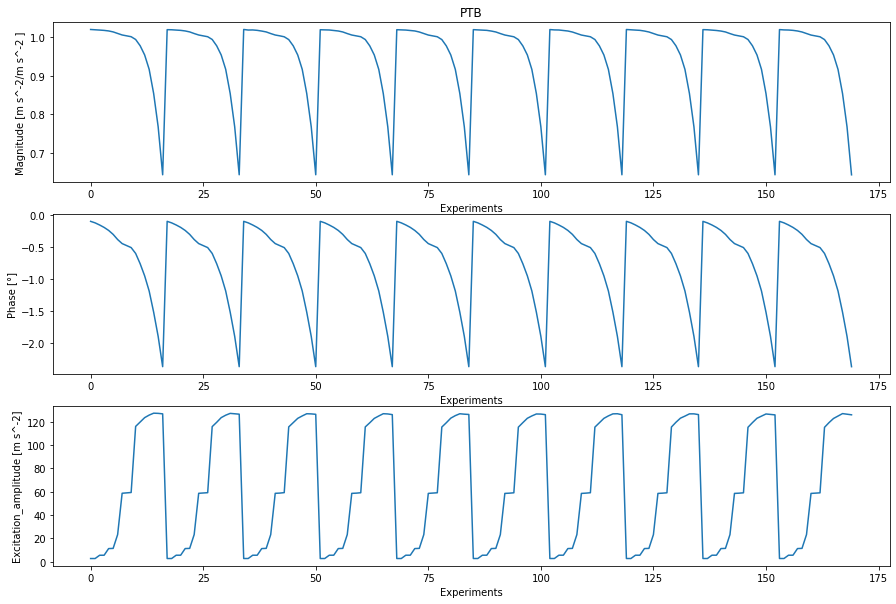

In [10]:
plot_dataset(whole_dataset_PTB,"PTB")

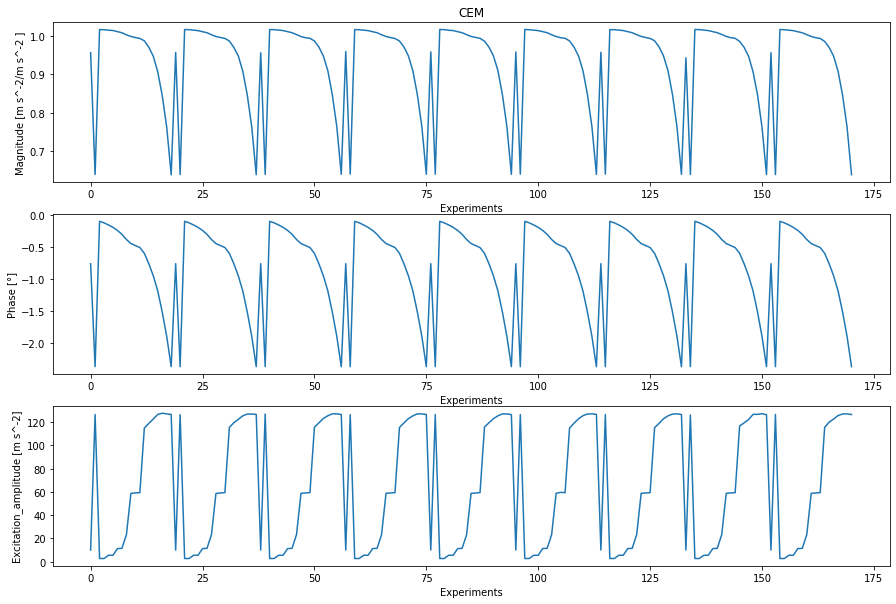

In [11]:
plot_dataset(whole_dataset_CEM,"CEM")

Cycles in CEM's dataset start with 80.0 Hz and 250.0 Hz instead of 10.0 Hz. These starting points are deleted in order to compare the cycles in a range from 10.0 Hz and 250.Hz.

In [12]:
delete_rows=[]

for k in range(0,171,19):
    i=k
    j=k+1
    delete_rows.append(i)
    delete_rows.append(j)
whole_dataset_CEM_new=whole_dataset_CEM.drop(axis=0,index=delete_rows)

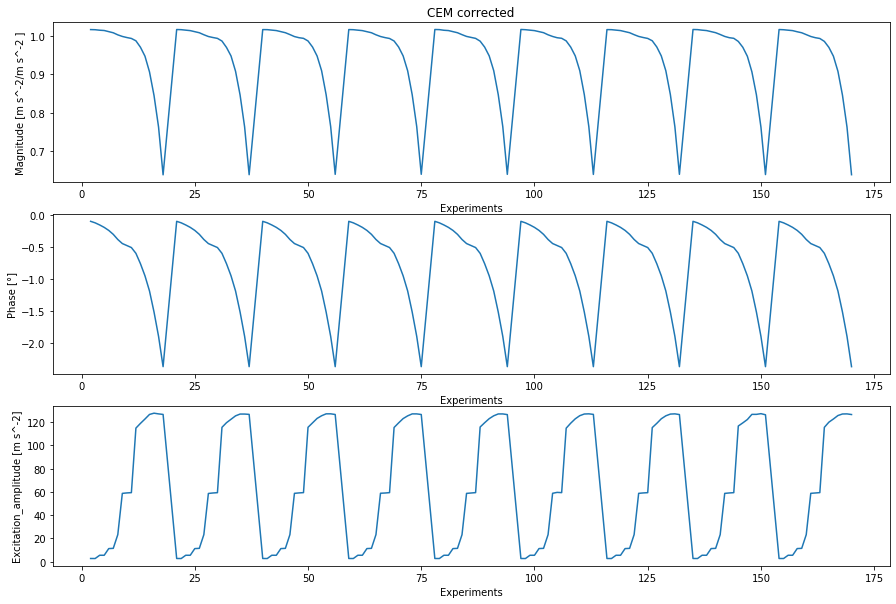

In [13]:
plot_dataset(whole_dataset_CEM_new,"CEM corrected")


In [14]:
def split_data_by_frequencies(dataset):
    dict_of_frequencies=dict(iter(dataset.groupby('Frequency [Hz]')))
    return dict_of_frequencies
    #list_of_frequencies=np.array([10,12.5,16,20,25,31.5,40,46.7,50,53.3,63,80,100,125,160,200,250])

In [15]:
#check if all frequencies are the same
PTB_separated_by_freq=split_data_by_frequencies(whole_dataset_PTB)
CEM_separated_by_freq=split_data_by_frequencies(whole_dataset_CEM)
CEM_separated_by_freq_new=split_data_by_frequencies(whole_dataset_CEM_new)
print("Frequencies - PTB:",PTB_separated_by_freq.keys())
print("Frequencies - CEM:",CEM_separated_by_freq.keys())

Frequencies - PTB: dict_keys([10.0, 12.5, 16.0, 20.0, 25.0, 31.5, 40.0, 46.7, 50.0, 53.3, 63.0, 80.0, 100.0, 125.0, 160.0, 200.0, 250.0])
Frequencies - CEM: dict_keys([10.0, 12.5, 16.0, 20.0, 25.0, 31.5, 40.0, 46.7, 50.0, 53.3, 63.0, 80.0, 100.0, 125.0, 160.0, 200.0, 250.0])


In [16]:
PTB_separated_by_freq.get(10).head(1)

Frequency [Hz]  Magnitude [m s^-2/m s^-2 ]  Uncertainty [m s^-2/m s^-2 ]  \
0            10.0                    1.019327                      0.000204   

   Phase [°]  Uncertainty[°]  Excitation_freq [Hz]  \
0  -0.094938         0.00054                  10.0   

   Excitation_amplitude [m s^-2]  Excitation_amplitude_uncert [m s^-2]  
0                          2.739                              0.000548

In [17]:
CEM_separated_by_freq.get(10).head(1)

Frequency [Hz]  Magnitude [m s^-2/m s^-2 ]  Uncertainty [m s^-2/m s^-2 ]  \
2            10.0                    1.016268                      0.001016   

   Phase [°]  Uncertainty[°]  Excitation_freq [Hz]  \
2  -0.094902        0.001748                  10.0   

   Excitation_amplitude [m s^-2]  Excitation_amplitude_uncert [m s^-2]  
2                         2.7543                              0.002754

In [18]:
q_names=list(PTB_separated_by_freq.get(10).columns)

The interval of  $\bar {x_{i}} -\sigma _{i}$ and $ \bar {x_{i}} +\sigma _{i}$  is plotted for each experiment and the quantities of interest.

In [19]:
def plot_x_plus_minus_sigma(dictionary,names):
    for val in dictionary.values():
    
        data_dict_amp = {}
        data_dict_amp['cycle'] =list(range(len(val)))
        data_dict_amp['lower'] = val["Magnitude [m s^-2/m s^-2 ]"].values-val["Uncertainty [m s^-2/m s^-2 ]"].values
        data_dict_amp['upper'] = val["Magnitude [m s^-2/m s^-2 ]"].values+val["Uncertainty [m s^-2/m s^-2 ]"].values
        dataset_amp = pd.DataFrame(data_dict_amp)

        data_dict_phase = {}
        data_dict_phase['cycle'] =list(range(len(val)))
        data_dict_phase['lower'] = val["Phase [°]"].values-val["Uncertainty[°]"].values
        data_dict_phase['upper'] = val["Phase [°]"].values+val["Uncertainty[°]"].values
        dataset_phase = pd.DataFrame(data_dict_phase)

        data_dict_excit = {}
        data_dict_excit['cycle'] =list(range(len(val)))
        data_dict_excit['lower'] = val["Excitation_amplitude [m s^-2]"].values-val["Excitation_amplitude_uncert [m s^-2]"].values
        data_dict_excit['upper'] = val["Excitation_amplitude [m s^-2]"].values+val["Excitation_amplitude_uncert [m s^-2]"].values
        dataset_excit = pd.DataFrame(data_dict_excit)


        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)

        for lower,upper,y in zip(dataset_amp['lower'],dataset_amp['upper'],range(len(dataset_amp))):
            plt.plot((lower,upper),(y,y),'ro-',color='orange')
        plt.yticks(range(len(dataset_amp)),list(dataset_amp['cycle']))
        plt.title(str(val[names[0]].values[0])+" Hz")
        plt.xlabel("Measurement cycle")
        plt.ylabel("Magnitude")

        plt.subplot(1,3,2)
        for lower,upper,y in zip(dataset_phase['lower'],dataset_phase['upper'],range(len(dataset_phase))):
            plt.plot((lower,upper),(y,y),'ro-',color='orange')
        plt.yticks(range(len(dataset_phase)),list(dataset_phase['cycle']))
        plt.title(str(val[names[0]].values[0])+" Hz")
        plt.xlabel("Measurement cycle")
        plt.ylabel("Phase")

        plt.subplot(1,3,3)
        for lower,upper,y in zip(dataset_excit['lower'],dataset_excit['upper'],range(len(dataset_excit))):
            plt.plot((lower,upper),(y,y),'ro-',color='orange')
        plt.yticks(range(len(dataset_excit)),list(dataset_excit['cycle']))
        plt.xlabel("Measurement cycle")
        plt.ylabel("Excitation amplitude")
        plt.title(str(val[names[0]].values[0])+" Hz")
    plt.show()

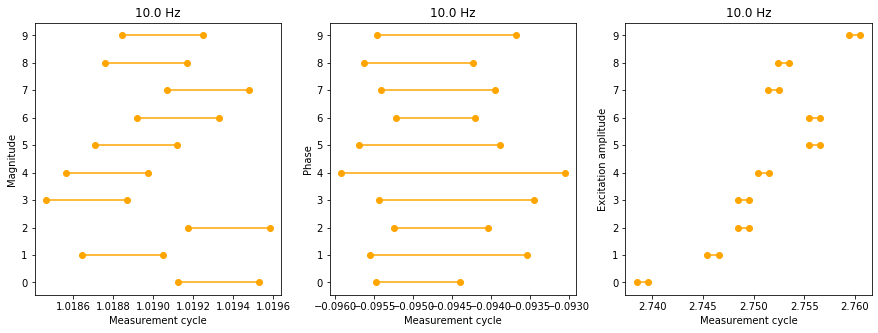

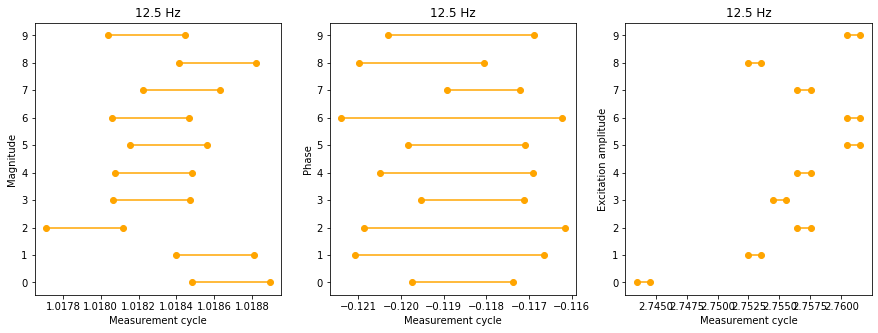

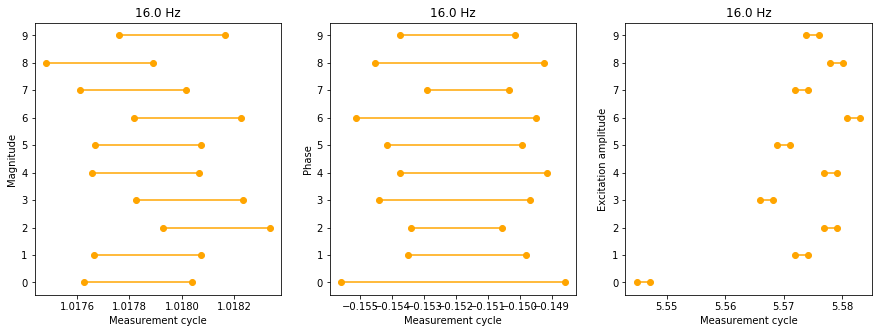

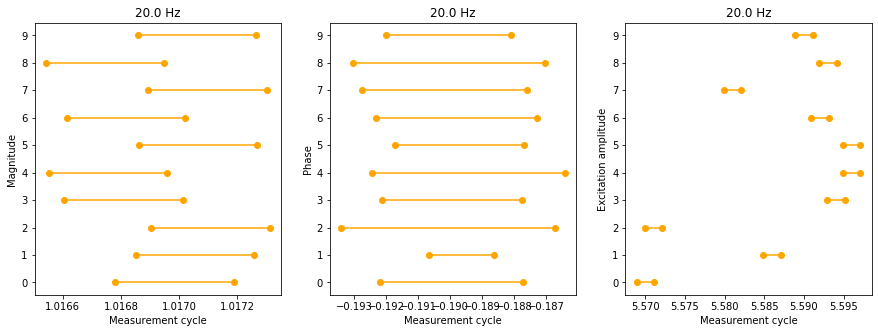

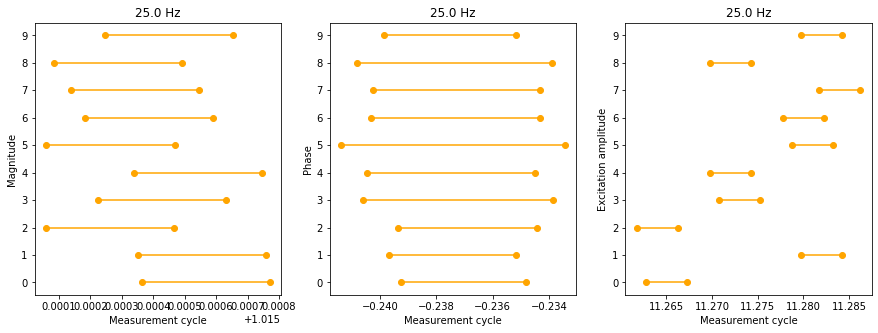

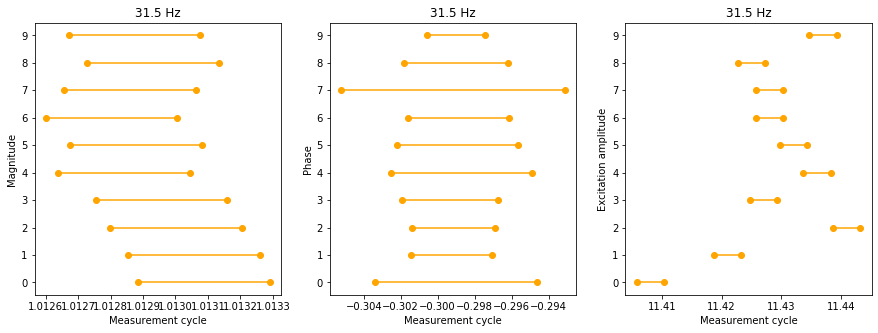

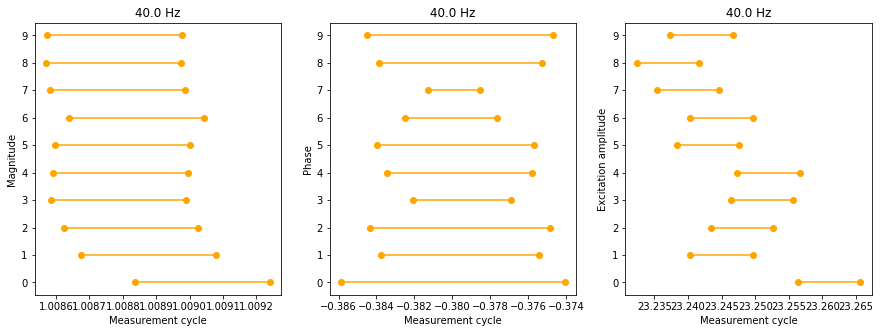

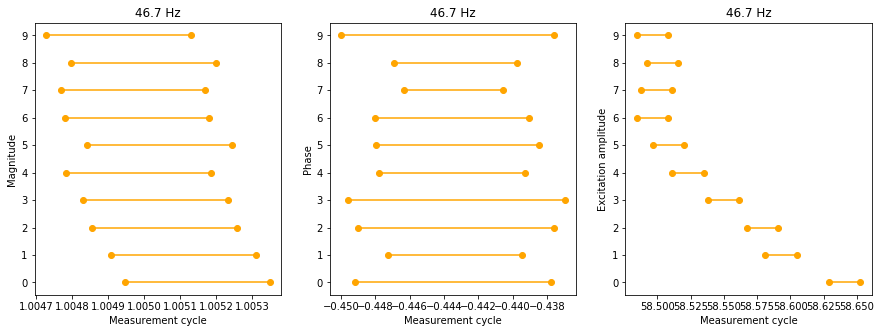

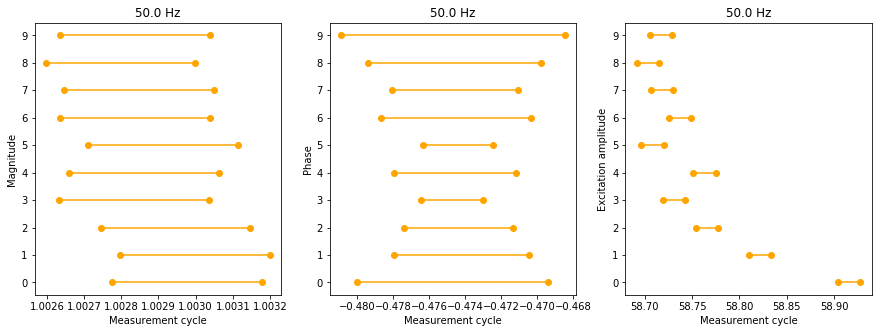

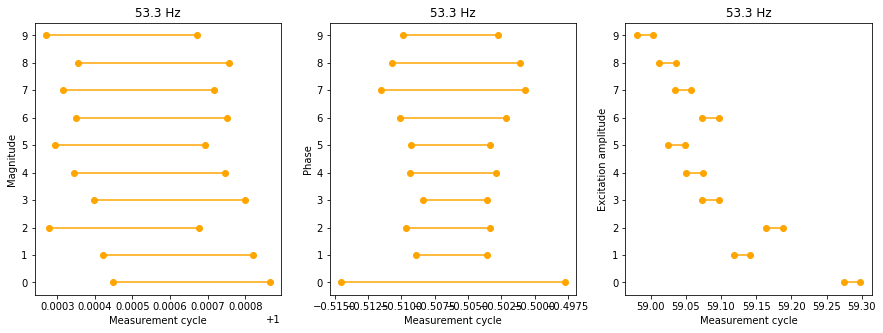

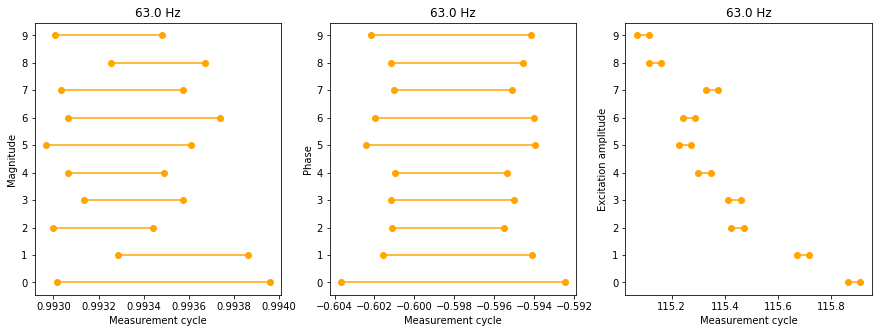

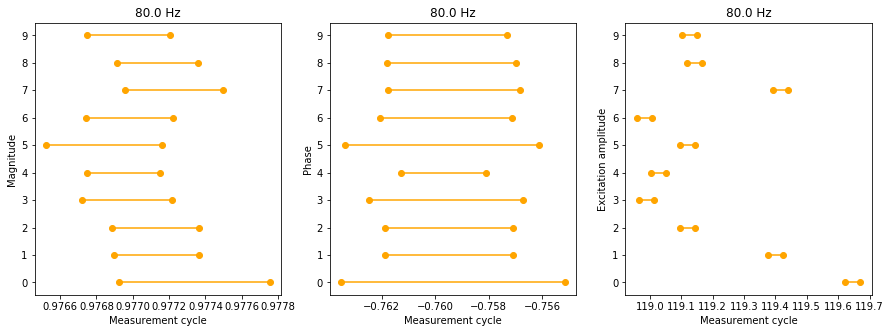

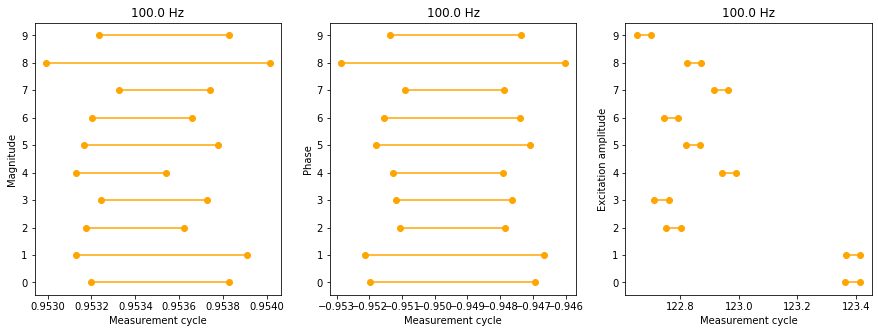

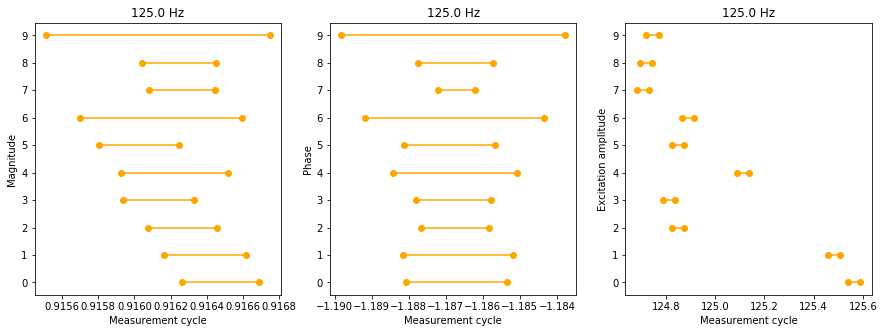

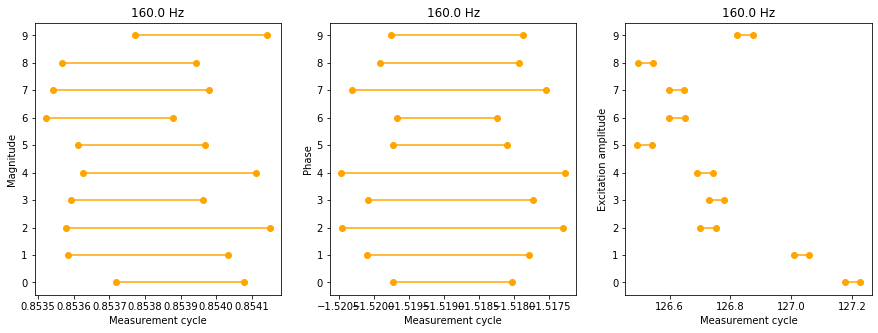

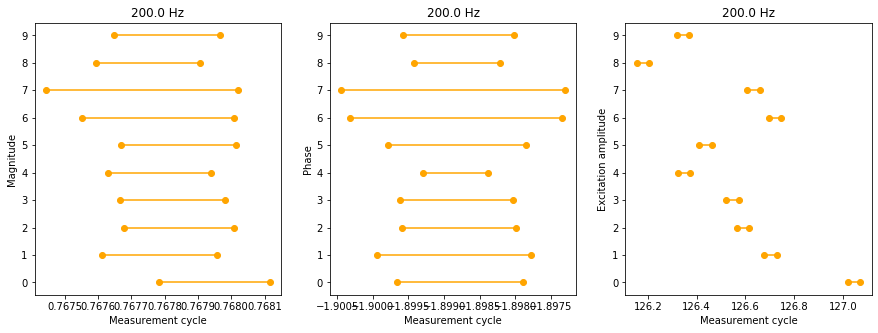

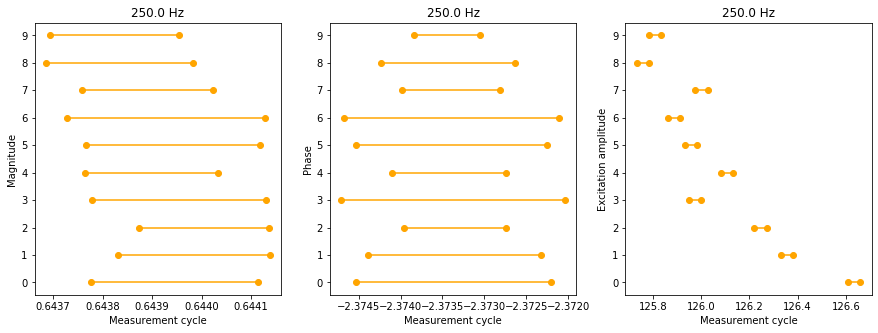

In [20]:
plot_x_plus_minus_sigma(PTB_separated_by_freq,q_names)

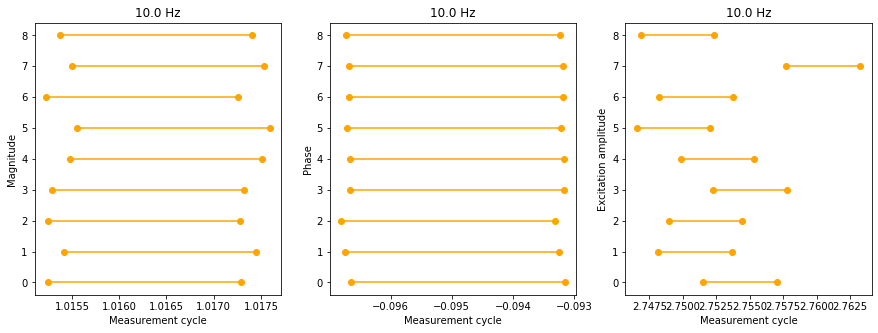

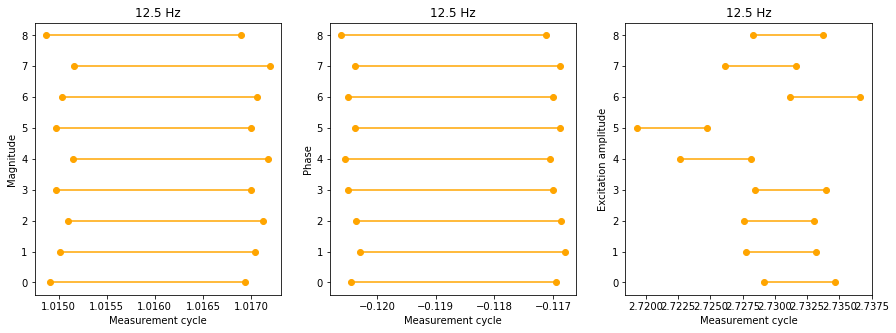

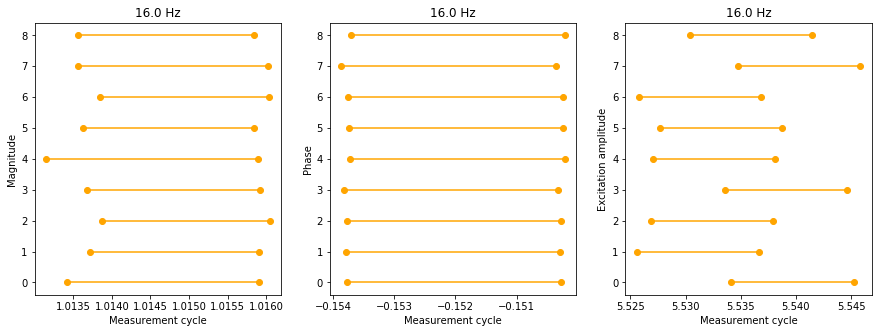

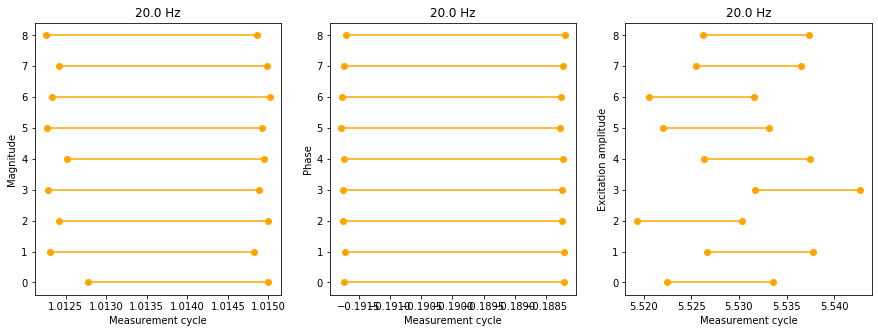

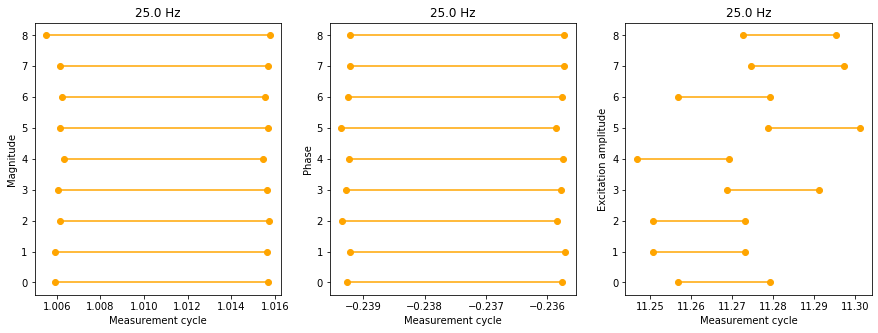

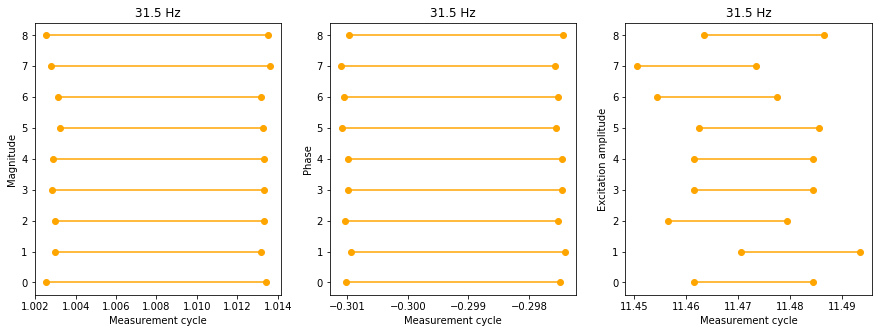

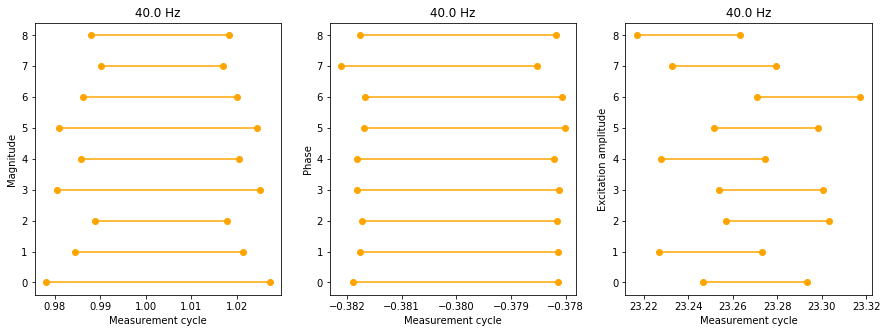

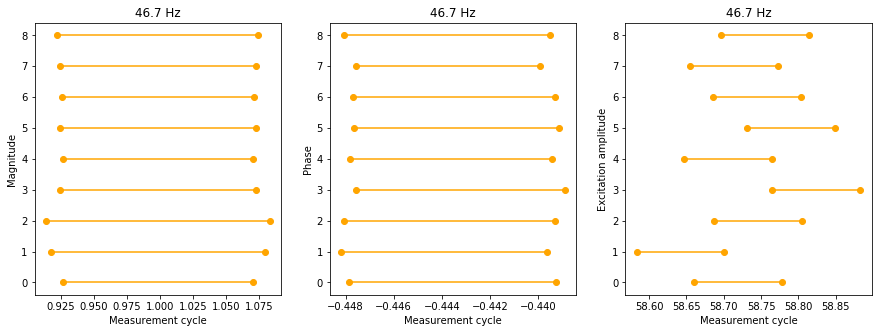

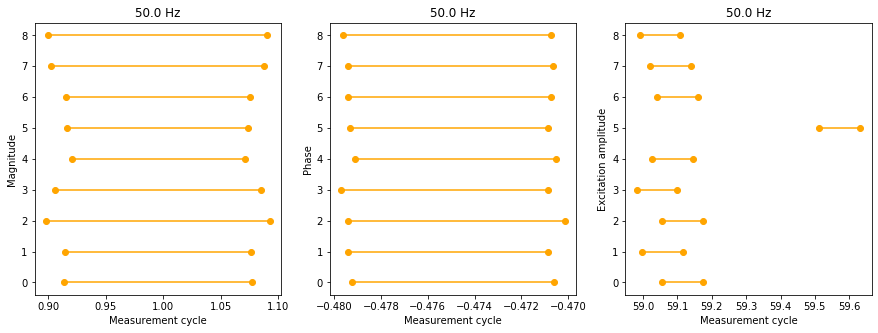

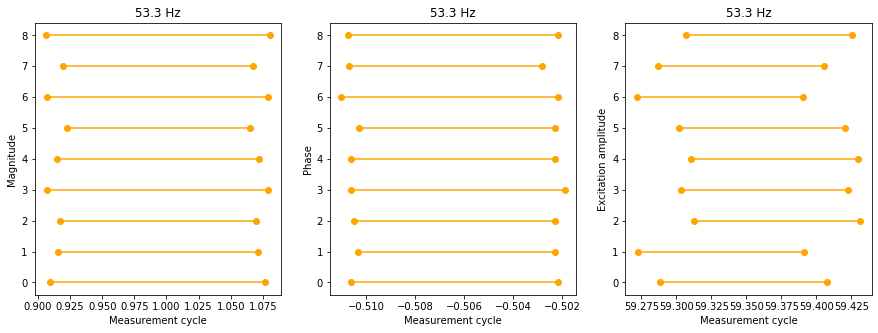

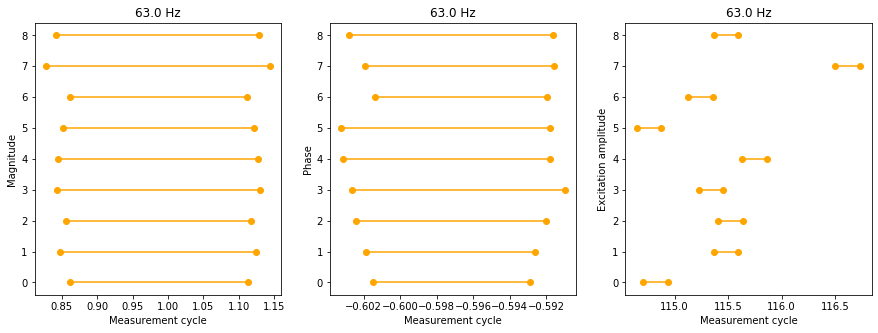

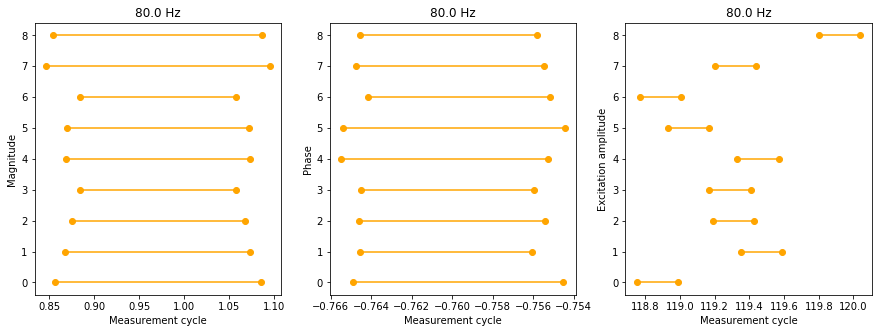

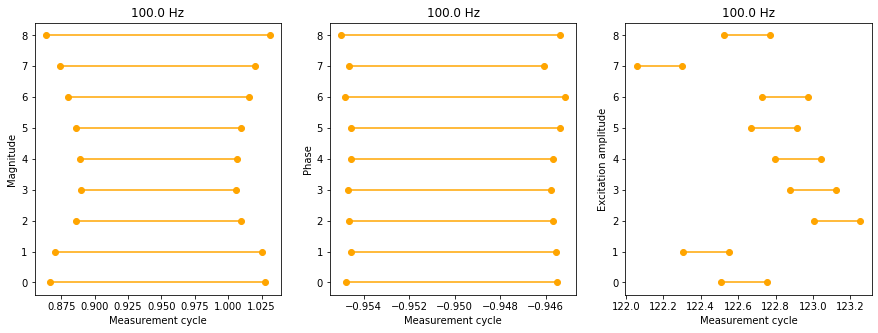

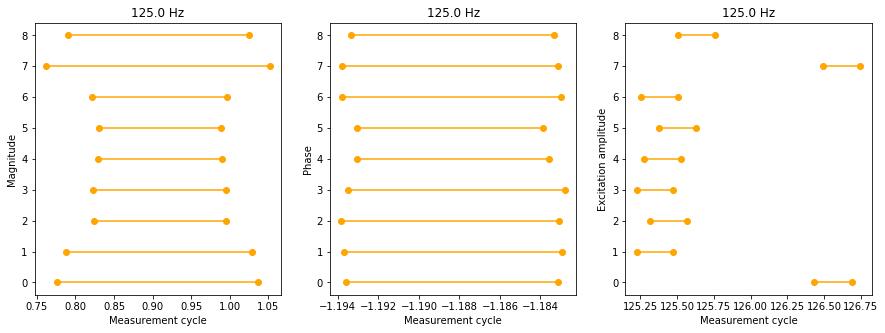

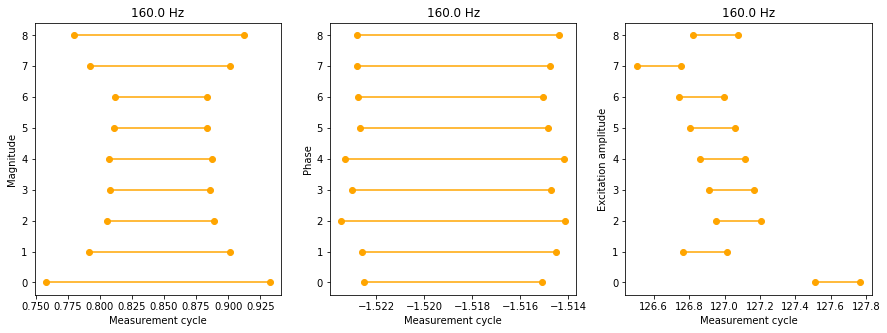

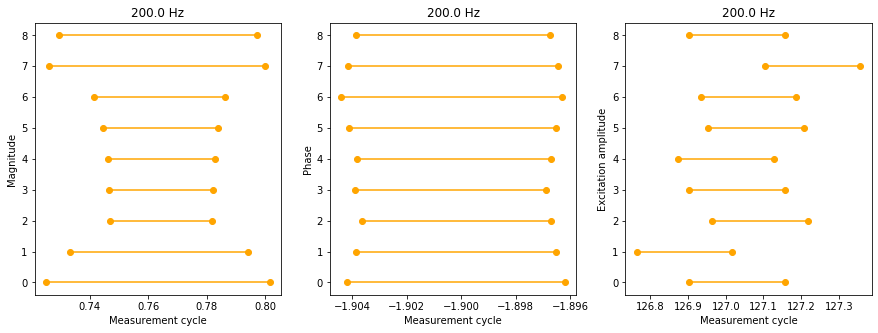

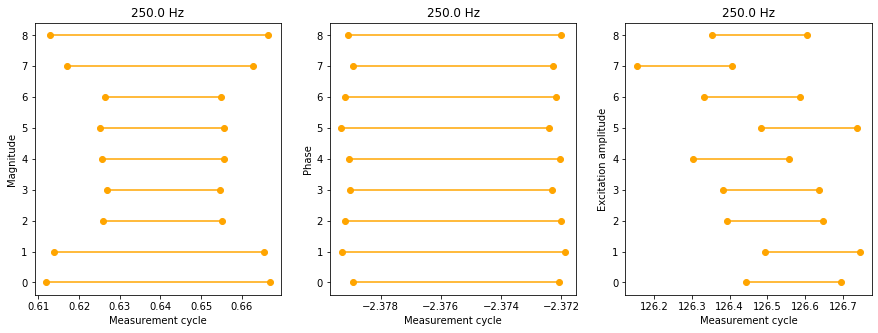

In [21]:
plot_x_plus_minus_sigma(CEM_separated_by_freq_new,q_names)

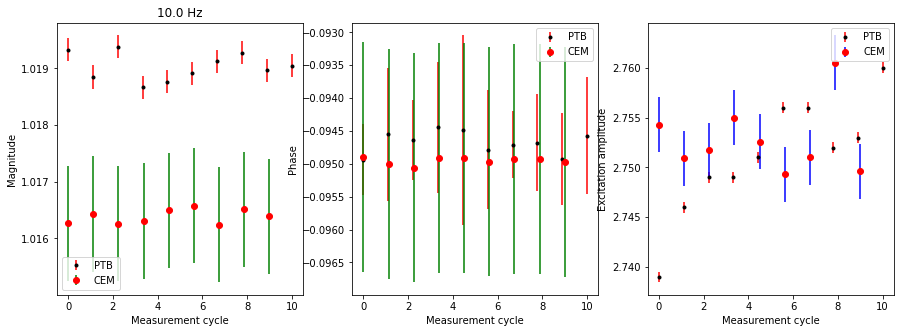

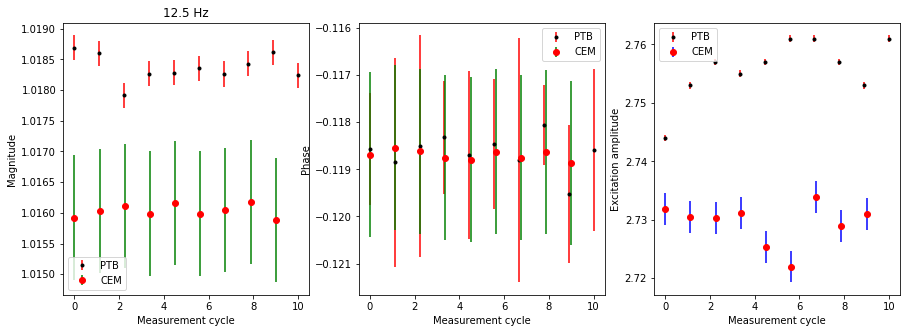

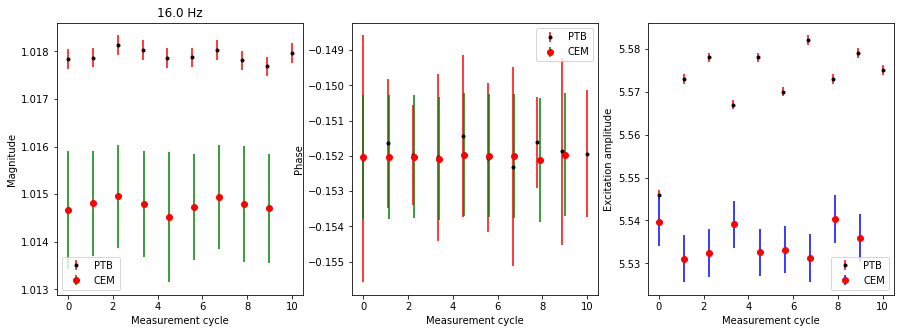

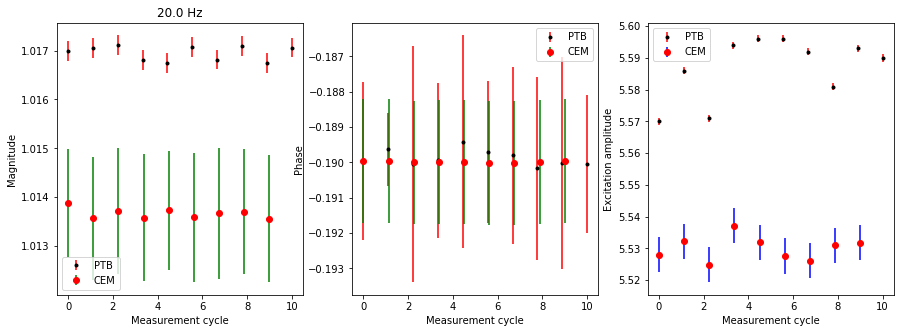

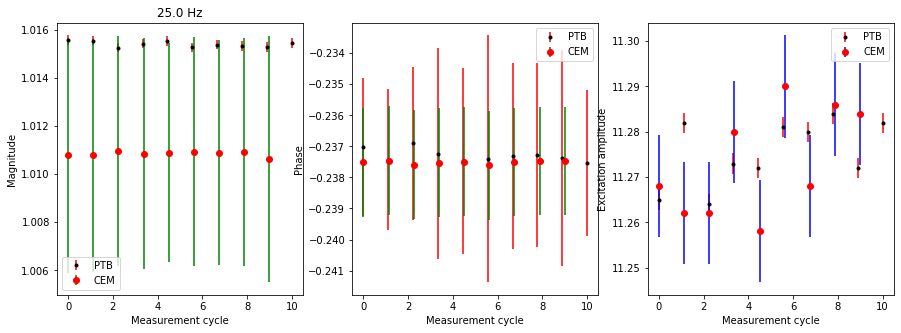

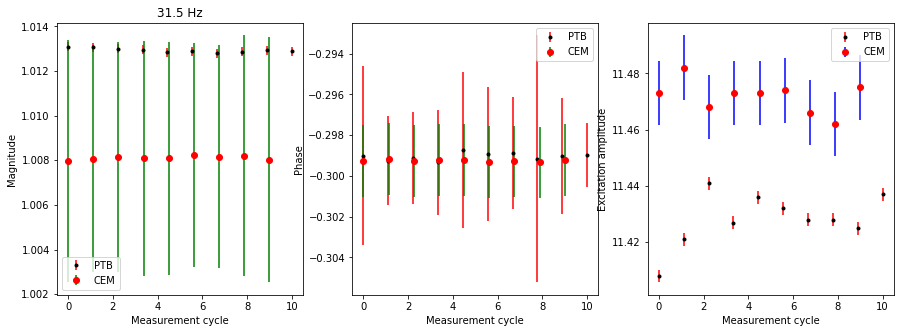

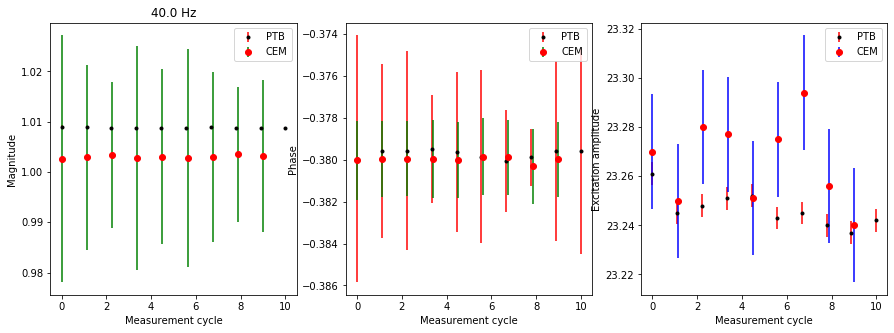

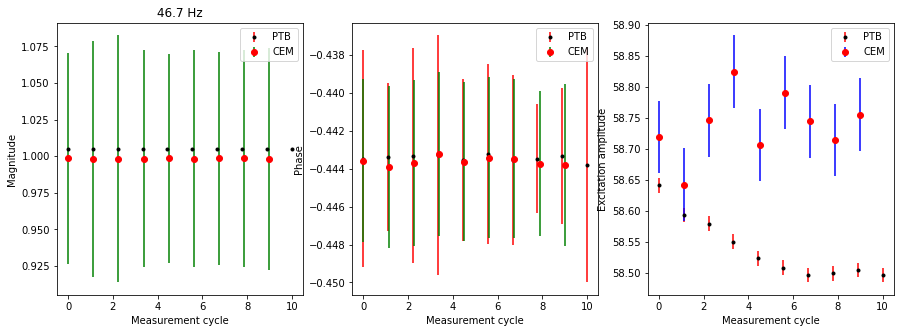

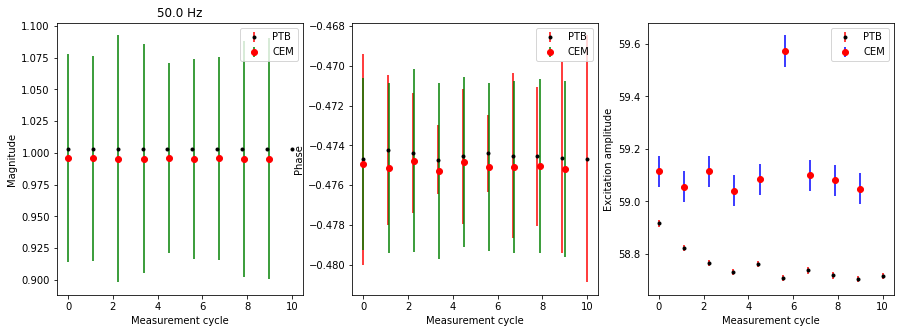

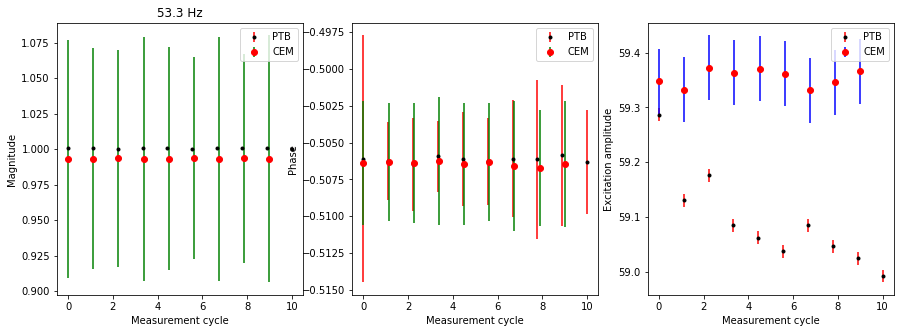

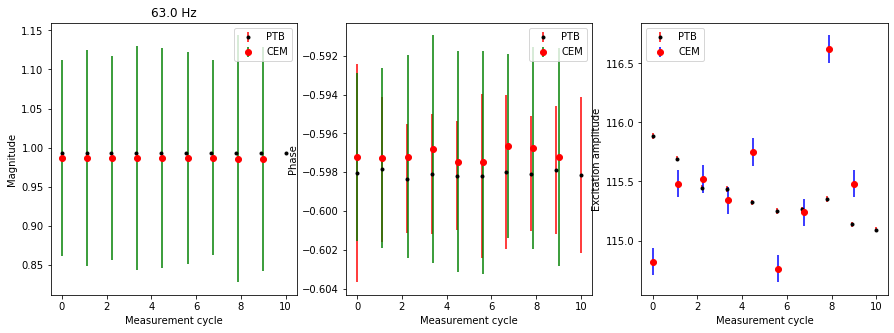

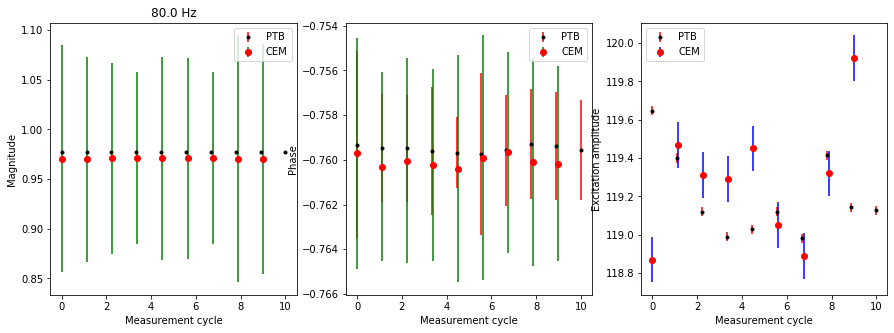

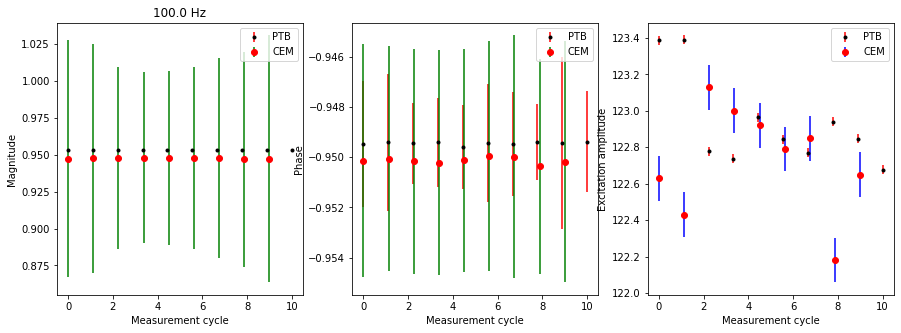

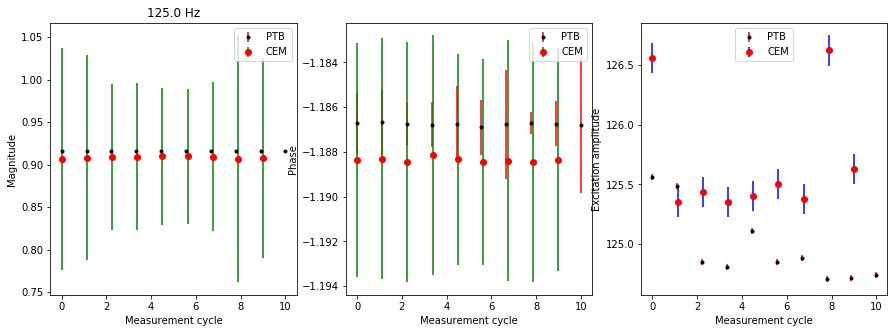

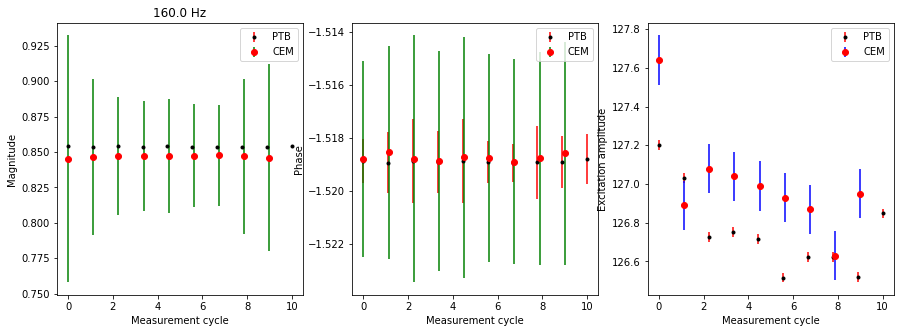

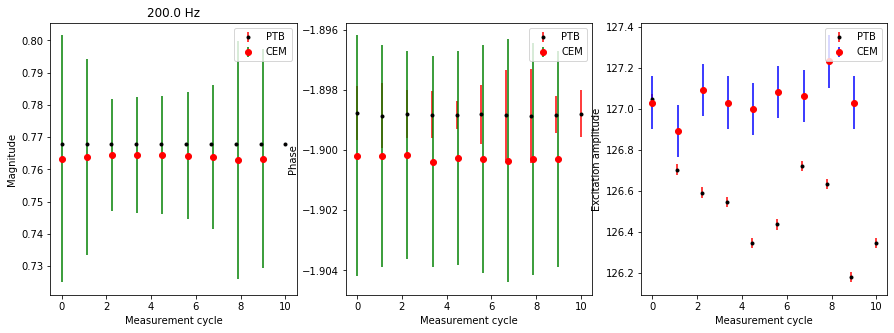

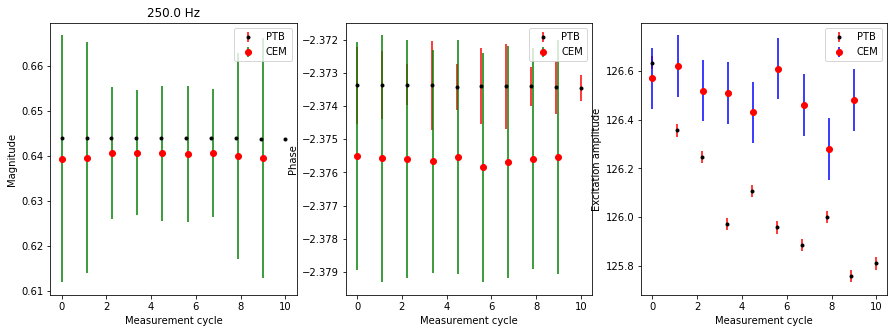

In [22]:
for val1,val2 in zip(PTB_separated_by_freq.values(),CEM_separated_by_freq_new.values()):  
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
 
    x = np.linspace(0,len(val1[q_names[1]]),len(val1[q_names[1]]))
    dy = val1[q_names[2]].values
    y = val1[q_names[1]].values
    plt.xlabel("Measurement cycle")
    plt.ylabel("Magnitude")
    plt.errorbar(x, y, yerr=dy, fmt='.k',ecolor='r',label="PTB")
    plt.title(str(val1[q_names[0]].values[0])+" Hz")
    
    x1 = np.linspace(0,len(val2[q_names[1]]),len(val2[q_names[1]]))
    plt.errorbar(x1,y=val2[q_names[1]].values,yerr =val2[q_names[2]].values,fmt='ro',ecolor='g',label="CEM")
    plt.legend()

    plt.subplot(1,3,2)
    x = np.linspace(0,len(val1[q_names[3]]),len(val1[q_names[3]]))
    dy = val1[q_names[4]].values
    y = val1[q_names[3]].values
    plt.xlabel("Measurement cycle")
    plt.ylabel("Phase")
    plt.errorbar(x, y, yerr=dy, fmt='.k',ecolor='r',label="PTB")
                          
    x1 = np.linspace(0,len(val2[q_names[3]]),len(val2[q_names[3]]))
    plt.errorbar(x1,y=val2[q_names[3]].values,yerr =val2[q_names[4]].values,fmt='ro',ecolor='g',label="CEM")
    plt.legend()
    
    plt.subplot(1,3,3)
    x = np.linspace(0,len(val1[q_names[6]]),len(val1[q_names[6]]))
    dy = val1[q_names[7]].values
    y = val1[q_names[6]].values
    plt.xlabel("Measurement cycle")
    plt.ylabel("Excitation amplitude")
    plt.errorbar(x, y, yerr=dy, fmt='.k',ecolor='r',label="PTB")
                          
    x1 = np.linspace(0,len(val2[q_names[6]]),len(val2[q_names[6]]))
    plt.errorbar(x1,y=val2[q_names[6]].values,yerr =val2[q_names[7]].values,fmt='ro',ecolor='b',label="CEM")
    plt.legend()
    plt.show()
    

## 3.2 Coefficient of variation

The coefficient of variation (CV) is a statistical measure of the dispersion of data points in a data series around the mean. The coefficient of variation represents the ratio of the standard deviation to the mean, and it is a useful statistic for comparing the degree of variation from one data series to another, even if the means are drastically different from one another.[1]

For each experiment, CV in percentages is calculated as:
$$CV={\frac {\sigma _{i}}{\bar {x_{i}}}} *100 $$
,where x represents magnitude, phase, and excitation amplituded and $\sigma$ corresponds to the assigned uncertainty values.

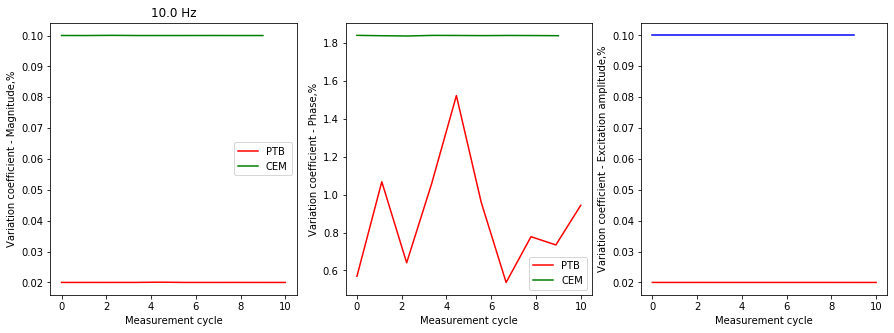

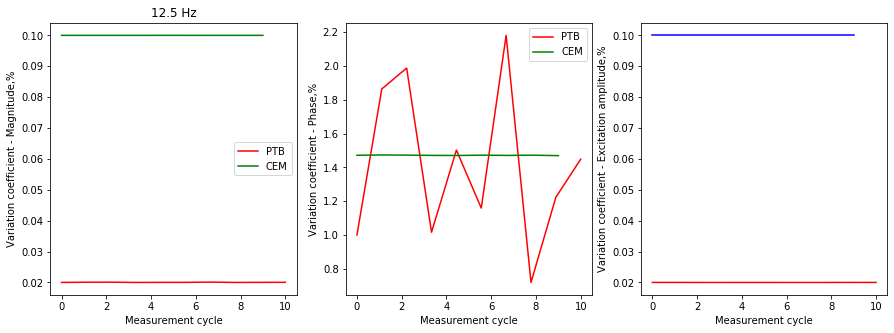

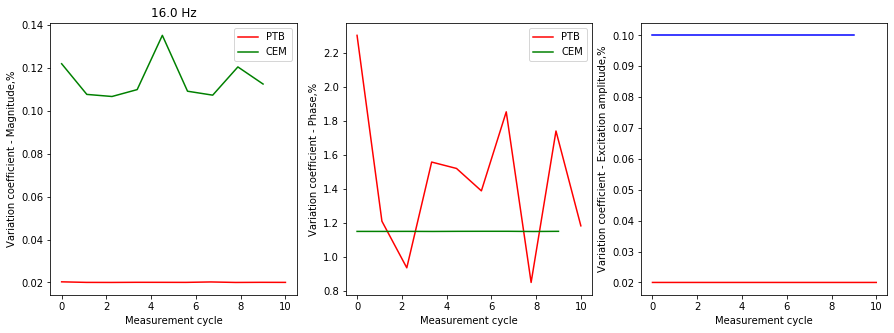

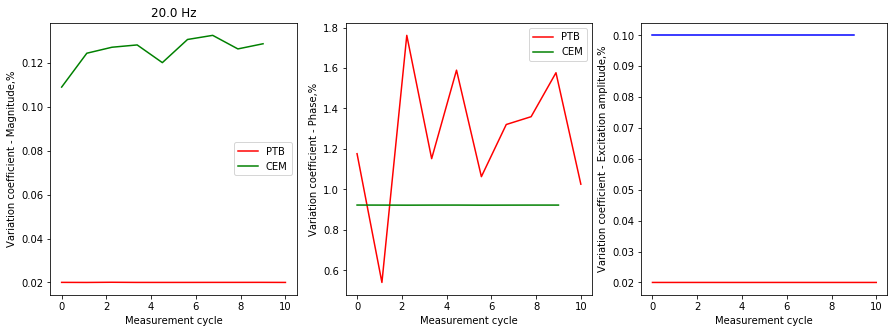

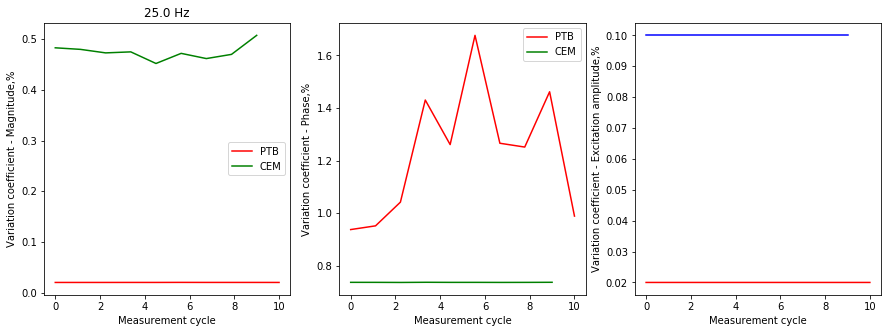

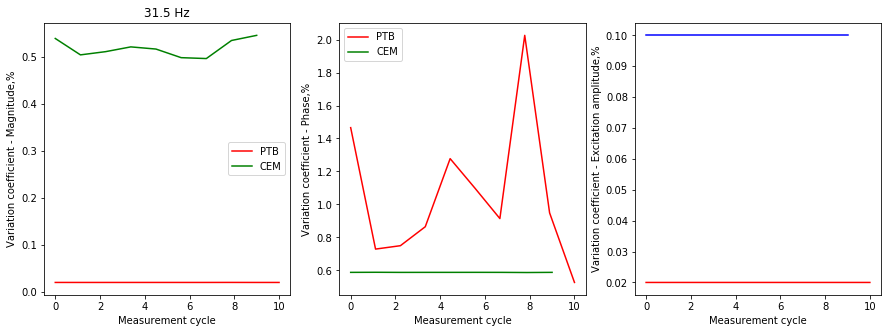

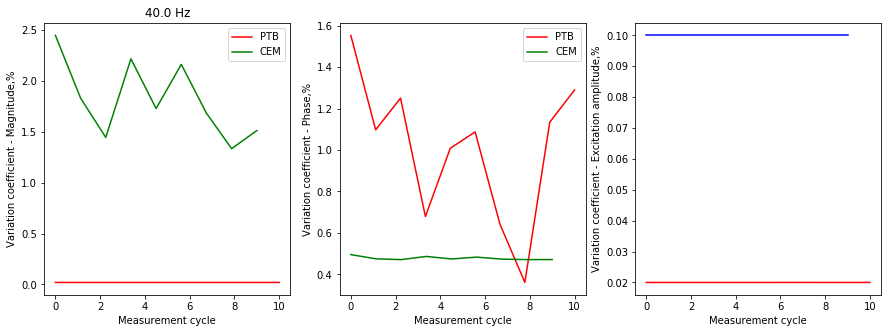

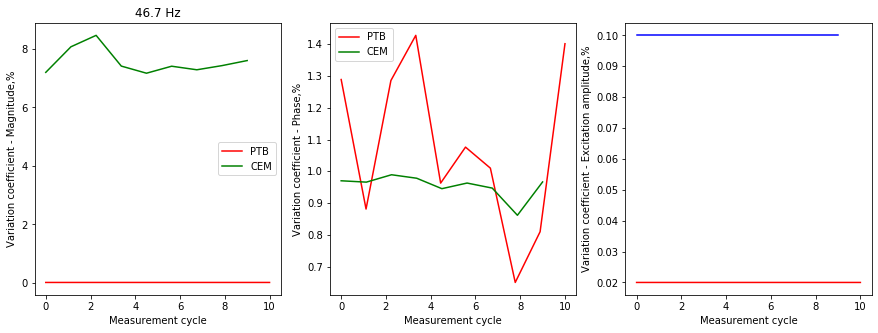

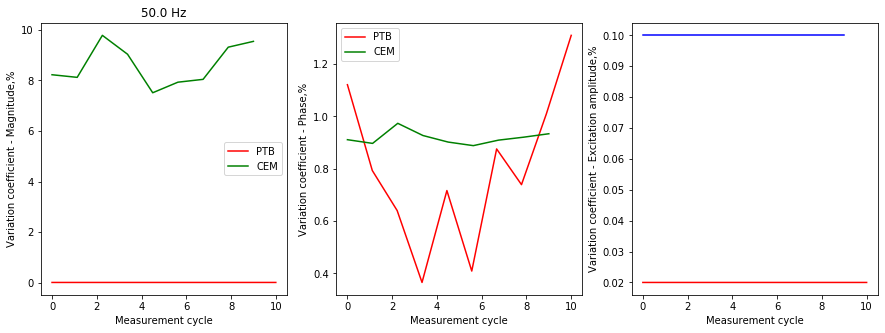

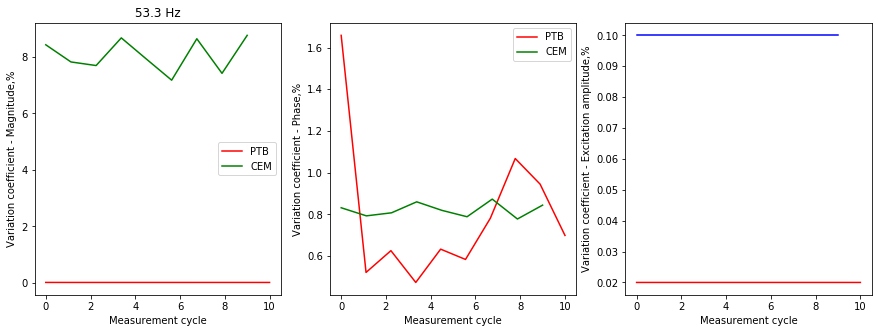

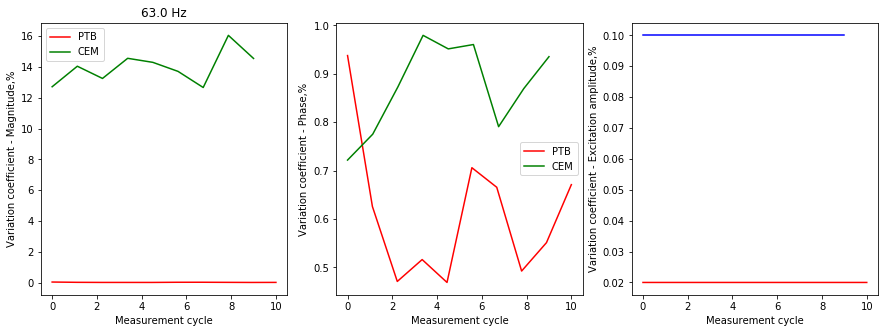

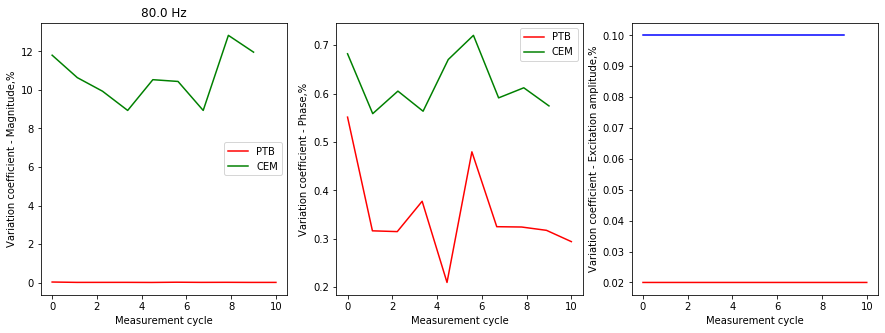

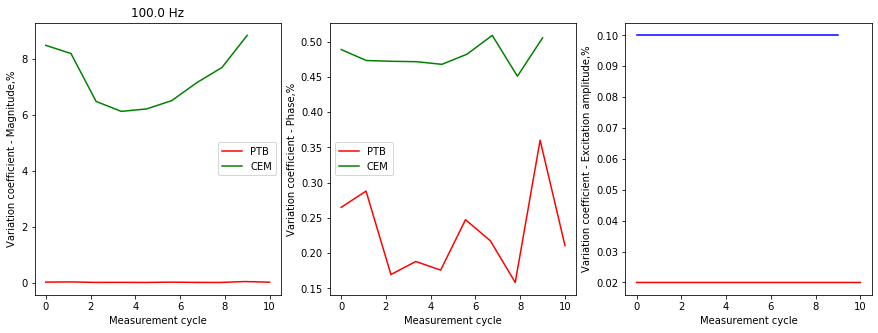

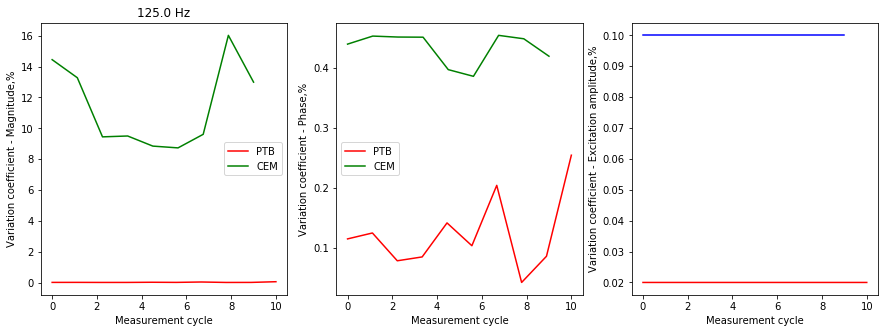

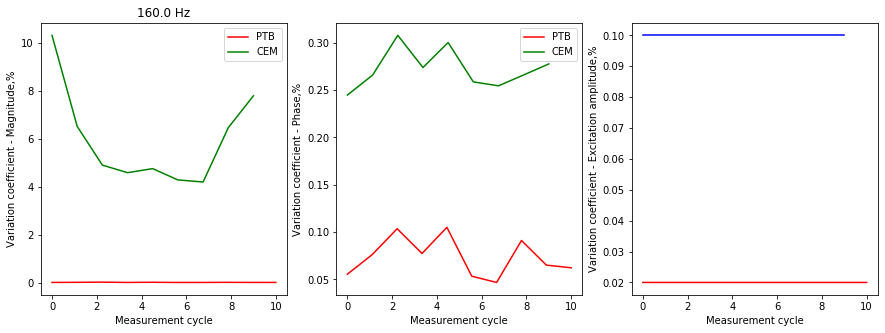

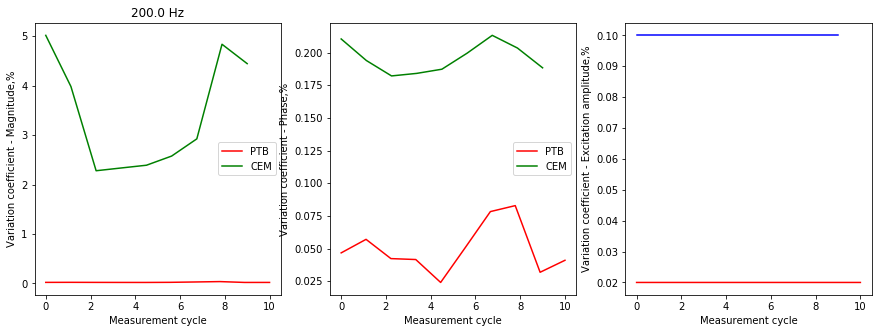

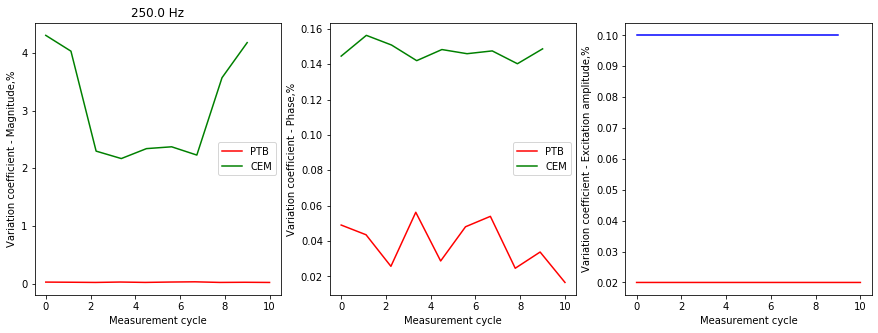

In [23]:
for val1,val2 in zip(PTB_separated_by_freq.values(),CEM_separated_by_freq_new.values()):  
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
 
    x = np.linspace(0,len(val1[q_names[1]]),len(val1[q_names[1]]))
    y_coef = (val1[q_names[2]].values/np.abs(val1[q_names[1]].values))*100
    plt.xlabel("Measurement cycle")
    plt.ylabel("Variation coefficient - Magnitude,%")
    plt.plot(x, y_coef,color='r',label="PTB")
    plt.title(str(val1[q_names[0]].values[0])+" Hz")
    x1 = np.linspace(0,len(val2[q_names[1]]),len(val2[q_names[1]])) 
    plt.plot(x1,(val2[q_names[2]].values/np.abs(val2[q_names[1]].values))*100,color='g',label="CEM")
    plt.legend()

    plt.subplot(1,3,2)
    x = np.linspace(0,len(val1[q_names[3]]),len(val1[q_names[3]]))
    y = (val1[q_names[4]].values/np.abs(val1[q_names[3]].values))*100
    plt.xlabel("Measurement cycle")
    plt.ylabel("Variation coefficient - Phase,%")
    plt.plot(x, y,color='r',label="PTB")
    x1 = np.linspace(0,len(val2[q_names[4]]),len(val2[q_names[4]]))                      
    plt.plot(x1,(val2[q_names[4]].values/np.abs(val2[q_names[3]].values))*100,color='g',label="CEM")
    plt.legend()
    
    plt.subplot(1,3,3)
    x = np.linspace(0,len(val1[q_names[6]]),len(val1[q_names[6]]))
    y = (val1[q_names[7]].values/np.abs(val1[q_names[6]].values))*100
    plt.xlabel("Measurement cycle")
    plt.ylabel("Variation coefficient - Excitation amplitude,%")
    plt.plot(x, y, color='r',label="PTB")
                          
    x1 = np.linspace(0,len(val2[q_names[6]]),len(val2[q_names[6]]))
    plt.plot(x1,(val2[q_names[7]].values/np.abs(val2[q_names[6]].values))*100,color='b',label="CEM")
    plt.show()
    

Mean variation coefficients are calculated as averages of all CVs at a given frequency:

$${\bar {CV}={\frac{\sum _{i=1}^{n}CV _{i}}{n}}}$$
,where n represents the number of experiments at a specific frequency.

In [24]:
def calculate_mean_variation_coefficient(dictionary):
    variation_coef=np.empty((len(dictionary),3))
    for val1,i in zip(dictionary.values(),range(len(dictionary))):  
        variation_coef[i,0]=((val1[q_names[2]].values/np.abs(val1[q_names[1]].values))*100).mean()
        variation_coef[i,1]=((val1[q_names[4]].values/np.abs(val1[q_names[3]].values))*100).mean()
        variation_coef[i,2]=((val1[q_names[7]].values/np.abs(val1[q_names[6]].values))*100).mean()
    return variation_coef

In [25]:
variation_coef_PTB=calculate_mean_variation_coefficient((PTB_separated_by_freq))
variation_coef_CEM=calculate_mean_variation_coefficient((CEM_separated_by_freq_new))

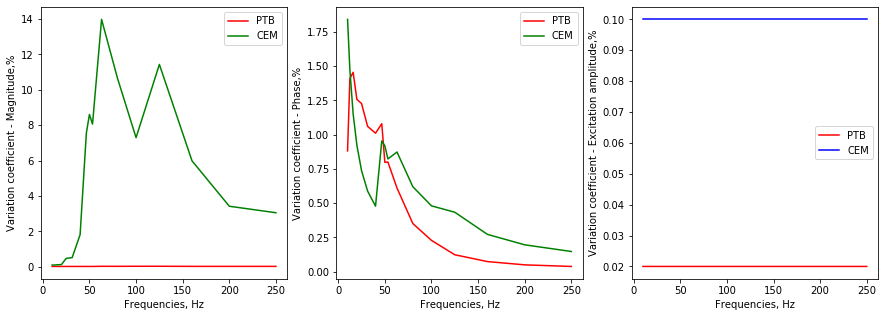

In [26]:
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    list_of_freq=[10,12.5,16,20,25,31.5,40,46.7,50,53.3,63,80,100,125,160,200,250]
    x = np.asarray(list_of_freq)
    y_coef = variation_coef_PTB[:,0]
    
    plt.xlabel("Frequencies, Hz")
    plt.ylabel("Variation coefficient - Magnitude,%")
    plt.plot(x, y_coef,color='r',label="PTB")
    plt.plot(x,variation_coef_CEM[:,0],color='g',label="CEM")
    plt.legend()

    plt.subplot(1,3,2)
    x = np.asarray(list_of_freq)
    plt.xlabel("Frequencies, Hz")
    plt.ylabel("Variation coefficient - Phase,%")
    plt.plot(x, variation_coef_PTB[:,1],color='r',label="PTB")
    plt.plot(x,variation_coef_CEM[:,1],color='g',label="CEM")
    plt.legend()
    
    plt.subplot(1,3,3)
    x = np.asarray(list_of_freq)
    plt.xlabel("Frequencies, Hz")
    plt.ylabel("Variation coefficient - Excitation amplitude,%")
    plt.plot(x, variation_coef_PTB[:,2], color='r',label="PTB")
    plt.plot(x, variation_coef_CEM[:,2],color='b',label="CEM")
    plt.legend() 
    plt.show()
    

# 4. ANOVA for experiments performed at a given frequency

There are three primary assumptions in ANOVA:

<br>*The responses for each factor level have a normal population distribution.*
<br>*These distributions have the same variance.*
<br>*The data are independent.*
<br>Violations to the first two that are not extreme can be considered not serious. The sampling distribution of the test statistic is fairly robust, especially as sample size increases and more so if the sample sizes for all factor levels are equal. If you conduct an ANOVA test, you should always try to keep the same sample sizes for each factor level.

If our samples have unequal variances (heteroscedasticity), on the other hand, it can affect the Type I error rate and lead to false positives. This is, basically, what equality of variances means.

<b>A general rule of thumb for equal variances is to compare the smallest and largest sample standard deviations. This is much like the rule of thumb for equal variances for the test for independent means. If the ratio of these two sample standard deviations falls within 0.5 to 2, then it may be that the assumption is not violated.<b>

## 4.1 Tests for equality of variances

In [27]:
def rule_of_thumb_ANOVA(dictionary, index):  
    ratio_amp=np.empty((len(dictionary.values())))
    ratio_ph=np.empty((len(dictionary.values())))
    ratio_ex=np.empty((len(dictionary.values())))
    for val,f in zip (dictionary.values(),range(len(dictionary.values()))):
            min_amp=min(val["Uncertainty [m s^-2/m s^-2 ]"].values)
            max_amp=max(val["Uncertainty [m s^-2/m s^-2 ]"].values)
            ratio_amp[f]=max_amp/min_amp

            min_ph=min(val["Uncertainty[°]"].values)
            max_ph=max(val["Uncertainty[°]"].values)
            ratio_ph[f]=max_ph/min_ph

            min_ex=min(val["Excitation_amplitude_uncert [m s^-2]"].values)
            max_ex=max(val["Excitation_amplitude_uncert [m s^-2]"].values)
            ratio_ex[f]=max_ex/min_ex
    
    ratios = {'Amplitude' : pd.Series(ratio_amp,index =index),
              'Phase' : pd.Series(ratio_ph,index =index),
              'Excitation amplitude' : pd.Series(ratio_ex,index =index),     
             }
    ratios=pd.DataFrame(ratios, index=index)  
    return ratios.style.applymap(lambda x: 'background-color : red' if x>2 else 'background-color : green')
 #red - variances are not equal
# green - variances are equal

In [28]:
rule_of_thumb_ANOVA(PTB_separated_by_freq,list_of_freq)

Additionally, another test for equality of variances has been performed. Bartlett’s test of homogeneity of variances is a test, that measures whether the variances are equal for all samples. If your data is normally distributed you can use Bartlett’s test instead of Levene’s.
Whether conducting Levene’s Test or Bartlett’s Test of homogeneity of variance we are dealing with two hypotheses. These two are simply put:

Null Hypothesis: the variances are equal across all samples/groups
Alternative Hypothesis:  the variances are not equal across all samples/groups [5]
<br> If the p-value is higher that 0.05, the null hypothesis cannot be rejected.

In [37]:
def Bartlett_test(dictionary,index,lab):

    barlet_amp=np.empty((len(dictionary.values())))
    barlet_ph=np.empty((len(dictionary.values())))
    barlet_ex=np.empty((len(dictionary.values())))
    for val,f in zip (dictionary.values(),range(len(dictionary.values()))):
        group=[None]*val.shape[0]
        for item in range(val.shape[0]):
            random1=np.random.normal(val["Magnitude [m s^-2/m s^-2 ]"].values[item], val["Uncertainty [m s^-2/m s^-2 ]"].values[item], 100)
            group[item]=random1
        if lab=="PTB": 
            bartlet_test = stats.bartlett(group[0],group[1],group[2],group[3],group[4],group[5],group[6],group[7],group[8],group[9])
        elif lab=="CEM":
            bartlet_test =stats.bartlett (group[0],group[1],group[2],group[3],group[4],group[5],group[6],group[7],group[8])
        barlet_amp[f]=bartlet_test[1]
       
     
    
    for val,f in zip (dictionary.values(),range(len(dictionary.values()))):
        
        for item in range(val.shape[0]):
            random1=np.random.normal(val["Phase [°]"].values[item], val["Uncertainty[°]"].values[item], 100)
            group[item]=random1
        if lab=="PTB": 
            bartlet_test = stats.bartlett(group[0],group[1],group[2],group[3],group[4],group[5],group[6],group[7],group[8],group[9])
        elif lab=="CEM":
            bartlet_test =stats.bartlett (group[0],group[1],group[2],group[3],group[4],group[5],group[6],group[7],group[8])
        barlet_ph[f]=bartlet_test[1]
     
                                                                      
    for val,f in zip (dictionary.values(),range(len(dictionary.values()))):
        
        for item in range(val.shape[0]):
            random1=np.random.normal(val["Excitation_amplitude [m s^-2]"].values[item], val["Excitation_amplitude_uncert [m s^-2]"].values[item], 100)
            group[item]=random1
        if lab=="PTB": 
            bartlet_test = stats.bartlett(group[0],group[1],group[2],group[3],group[4],group[5],group[6],group[7],group[8],group[9])
        elif lab=="CEM":
            bartlet_test =stats.bartlett (group[0],group[1],group[2],group[3],group[4],group[5],group[6],group[7],group[8])
        barlet_ex[f]=bartlet_test[1]
        
    barletts = {'Amplitude' : pd.Series(barlet_amp,index =index),
              'Phase' : pd.Series(barlet_ph,index =index),
              'Excitation amplitude' : pd.Series(barlet_ex,index =index),     
             }
    barletts=pd.DataFrame(barletts, index=index)    
    return barletts.style.applymap(lambda x: 'background-color : red' if x<0.05 else 'background-color : green')
 #red - variances are not equal
# green - variances are equal
                 

In [38]:
Bartlett_test(PTB_separated_by_freq,list_of_freq,"PTB")

A one-way ANOVA uses the following null and alternative hypotheses:

<br>H0 (a null hypothesis): μ1 = μ2 = μ3 = … = μk (all the population means are equal)
<br>H1 (a research hypothesis): at least one population mean is different from the rest.
<br> If the p-value is higher that 0.05, the null hypothesis cannot be rejected. [4]

In [39]:
def ANOVA_through_experiments(dictionary,index,lab):
 
    p=np.empty((len(dictionary.values())))

    for val,f in zip (dictionary.values(),range(len(dictionary.values()))):
        group=[None]*val.shape[0]
        for item in range(val.shape[0]):
            random1=np.random.normal(val["Magnitude [m s^-2/m s^-2 ]"].values[item], val["Uncertainty [m s^-2/m s^-2 ]"].values[item], 100)
            group[item]=random1
            
        if lab=="PTB": 
            F_statistic, pVal = stats.f_oneway(group[0],group[1],group[2],group[3],group[4],group[5],group[6],group[7],group[8],group[9]) 
        elif lab=="CEM":
            F_statistic, pVal = stats.f_oneway(group[0],group[1],group[2],group[3],group[4],group[5],group[6],group[7],group[8])
        p[f]=pVal
     
    df=pd.DataFrame(p,columns=["p-value (Amplitude) "], index=index) 

          
    for val,f in zip (dictionary.values(),range(len(dictionary.values()))):
        group=[None]*val.shape[0]
        for item in range(val.shape[0]):
            random1=np.random.normal(val["Phase [°]"].values[item], val["Uncertainty[°]"].values[item], 100)
            group[item]=random1
        if lab=="PTB": 
            F_statistic, pVal = stats.f_oneway(group[0],group[1],group[2],group[3],group[4],group[5],group[6],group[7],group[8],group[9])
            p[f]=pVal
        elif lab=="CEM":
            F_statistic, pVal = stats.f_oneway(group[0],group[1],group[2],group[3],group[4],group[5],group[6],group[7],group[8])
        p[f]=pVal
  
    df["p-value (Phase) "]=p    
               
    for val,f in zip (dictionary.values(),range(len(PTB_separated_by_freq.values()))):
        group=[None]*val.shape[0]
        for item in range(val.shape[0]):
            random1=np.random.normal(val["Excitation_amplitude [m s^-2]"].values[item], val["Excitation_amplitude_uncert [m s^-2]"].values[item], 100)
            group[item]=random1
        if lab=="PTB": 
            F_statistic, pVal = stats.f_oneway(group[0],group[1],group[2],group[3],group[4],group[5],group[6],group[7],group[8],group[9])
            p[f]=pVal
        elif lab=="CEM":
            F_statistic, pVal = stats.f_oneway(group[0],group[1],group[2],group[3],group[4],group[5],group[6],group[7],group[8]) 
        p[f]=pVal      
        
    df["p-value (Excitatiom amplitude) "]=p  
    return df.style.applymap(lambda x: 'background-color : yellow' if x<0.05 else 'background-color : green')

 #yellow - the null hypothesis can be rejected. 
# green - the null hypothesis cannot be rejected. 

In [40]:
ANOVA_through_experiments(PTB_separated_by_freq,list_of_freq,"PTB")

In [41]:
ANOVA_through_experiments(CEM_separated_by_freq_new,list_of_freq,"CEM")

# 5. Case study 1: Calculate En values for estimated means and standard deviations

## 5.1 The probability distribution

The estimated mean values at each specific frequencies are calculated as:
$${\bar {x}}=\frac {\sum _{i=1}^{n}x_{i}}{n}$$,

where:
<br>x represents the value of an experiment at a specific frequency
<br>n is the number of experiments at a specific frequency.

The standard deviation of the $\bar {x}$ is $\sigma$, calculated as:
$${\sigma}=\sqrt{\frac {\sum _{i=1}^{n}{(x_{i}-\bar {x})}^{2}}{n}}$$



Mean and standard deviation of all quantities and uncertainties are calculated at every frequency by the function calculate_means_and_std.

In [42]:
def calculate_means_and_std(dictionary,names_mean,names_std):
    mean_list=[]
    stdev_list=[]
    for val in dictionary.values():
        mean_list.append(val.mean())
        stdev_list.append(np.std(val,ddof=0))
    mean_array=np.asarray(mean_list)
    stdev_array=np.asarray(stdev_list)
    mean_array=pd.DataFrame(mean_array,columns=names_mean)
    stdev_array=pd.DataFrame(stdev_array,columns=names_std)
    avg_and_std=pd.concat([mean_array,stdev_array],axis=1)
    return avg_and_std

In [43]:
means=["Means - "]*len(q_names)
stdevs=["Stdev - "]*len(q_names)
mean_names=[means[i] + q_names[i] for i in range(len(q_names))]
stdev_names=[stdevs[i] + q_names[i] for i in range(len(q_names))]
avg_std_PTB=calculate_means_and_std(PTB_separated_by_freq,mean_names,stdev_names)
avg_std_CEM=calculate_means_and_std(CEM_separated_by_freq_new,mean_names,stdev_names)
avg_std_PTB.head(2)

Means - Frequency [Hz]  Means - Magnitude [m s^-2/m s^-2 ]  \
0                    10.0                            1.019030   
1                    12.5                            1.018366   

   Means - Uncertainty [m s^-2/m s^-2 ]  Means - Phase [°]  \
0                              0.000204          -0.094674   
1                              0.000204          -0.118641   

   Means - Uncertainty[°]  Means - Excitation_freq [Hz]  \
0                0.000834                          10.0   
1                0.001673                          12.5   

   Means - Excitation_amplitude [m s^-2]  \
0                                 2.7511   
1                                 2.7559   

   Means - Excitation_amplitude_uncert [m s^-2]  Stdev - Frequency [Hz]  \
0                                      0.000550                     0.0   
1                                      0.000551                     0.0   

   Stdev - Magnitude [m s^-2/m s^-2 ]  Stdev - Uncertainty [m s^-2/m s^-2 ]  \
0                            0.000231                          2.244188e-07   
1                            0.000218                          3.522929e-07   

   Stdev - Phase [°]  Stdev - Uncertainty[°]  Stdev - Excitation_freq [Hz]  \
0           0.000163                0.000266                           0.0   
1           0.000368                0.000537                           0.0   

   Stdev - Excitation_amplitude [m s^-2]  \
0                               0.005594   
1                               0.004908   

   Stdev - Excitation_amplitude_uncert [m s^-2]  
0                                  1.089524e-06  
1                                  9.512179e-07

In [44]:
avg_std_CEM.head(2)

Means - Frequency [Hz]  Means - Magnitude [m s^-2/m s^-2 ]  \
0                    10.0                            1.016387   
1                    12.5                            1.016034   

   Means - Uncertainty [m s^-2/m s^-2 ]  Means - Phase [°]  \
0                              0.001016          -0.094954   
1                              0.001016          -0.118696   

   Means - Uncertainty[°]  Means - Excitation_freq [Hz]  \
0                0.001748                          10.0   
1                0.001746                          12.5   

   Means - Excitation_amplitude [m s^-2]  \
0                               2.752767   
1                               2.729456   

   Means - Excitation_amplitude_uncert [m s^-2]  Stdev - Frequency [Hz]  \
0                                      0.002753                     0.0   
1                                      0.002729                     0.0   

   Stdev - Magnitude [m s^-2/m s^-2 ]  Stdev - Uncertainty [m s^-2/m s^-2 ]  \
0                            0.000117                          1.533767e-07   
1                            0.000096                          1.003105e-07   

   Stdev - Phase [°]  Stdev - Uncertainty[°]  Stdev - Excitation_freq [Hz]  \
0           0.000048            1.673027e-07                           0.0   
1           0.000097            4.648099e-08                           0.0   

   Stdev - Excitation_amplitude [m s^-2]  \
0                               0.003282   
1                               0.003421   

   Stdev - Excitation_amplitude_uncert [m s^-2]  
0                                      0.000003  
1                                      0.000003

It is necessary to assess this approach to see if a normal distribution contains all experimental intervals. Further assessment would involve an identification of outliers (values which fall out of the region ${\bar {x}}+-3*\sigma $).

In [45]:
def normal_distribution(avg_and_std):
    for val1 in range(avg_and_std.shape[0]):  
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
 
        x = np.linspace(avg_and_std["Means - Magnitude [m s^-2/m s^-2 ]"][val1] - 3*avg_and_std["Stdev - Magnitude [m s^-2/m s^-2 ]"][val1] , avg_and_std["Means - Magnitude [m s^-2/m s^-2 ]"][val1] + 3*avg_and_std["Stdev - Magnitude [m s^-2/m s^-2 ]"][val1], 100)
        plt.plot(x, scipy.stats.norm.pdf(x, avg_and_std["Means - Magnitude [m s^-2/m s^-2 ]"][val1], avg_and_std["Stdev - Magnitude [m s^-2/m s^-2 ]"][val1]))
        plt.title(str(avg_and_std["Means - Frequency [Hz]"].values[val1])+" Hz")
        plt.xlabel("Magnitude")
    
        plt.subplot(1,3,2)
        x1 = np.linspace(avg_and_std["Means - Phase [°]"][val1] - 3*avg_and_std["Stdev - Phase [°]"][val1] , avg_and_std["Means - Phase [°]"][val1] + 3*avg_and_std["Stdev - Phase [°]"][val1], 100)
        plt.plot(x1, scipy.stats.norm.pdf(x1, avg_and_std["Means - Phase [°]"][val1], avg_and_std["Stdev - Phase [°]"][val1]))
        plt.xlabel("Phase")
    
    
        plt.subplot(1,3,3)
                          
        x2 = np.linspace(avg_and_std["Means - Excitation_amplitude [m s^-2]"][val1] - 3*avg_and_std["Stdev - Excitation_amplitude [m s^-2]"][val1] , avg_and_std["Means - Excitation_amplitude [m s^-2]"][val1] + 3*avg_and_std["Stdev - Excitation_amplitude [m s^-2]"][val1], 100)
        plt.plot(x2, scipy.stats.norm.pdf(x2, avg_and_std["Means - Excitation_amplitude [m s^-2]"][val1], avg_and_std["Stdev - Excitation_amplitude [m s^-2]"][val1]))
        plt.xlabel("Excitation amplitude")
        plt.show()

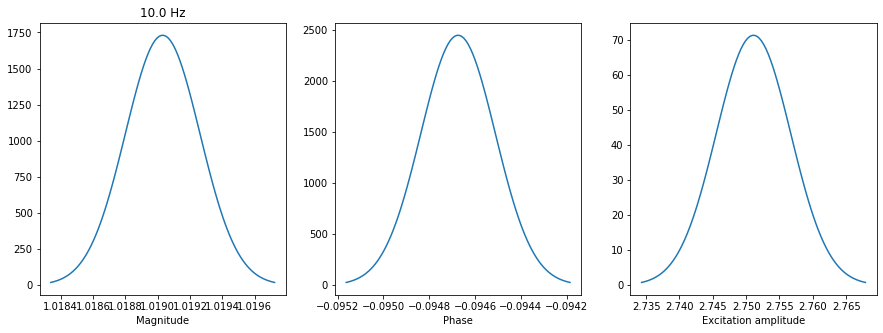

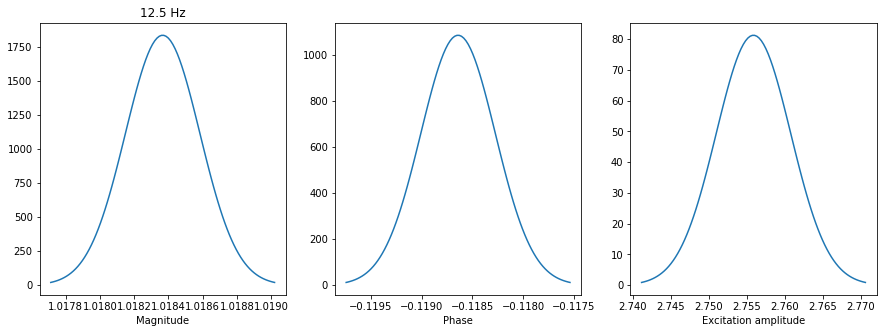

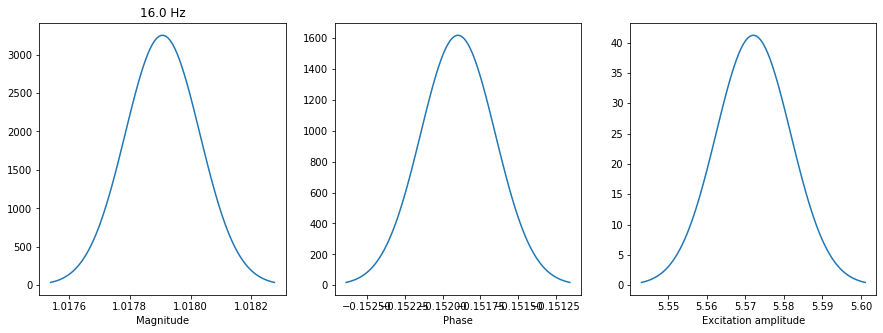

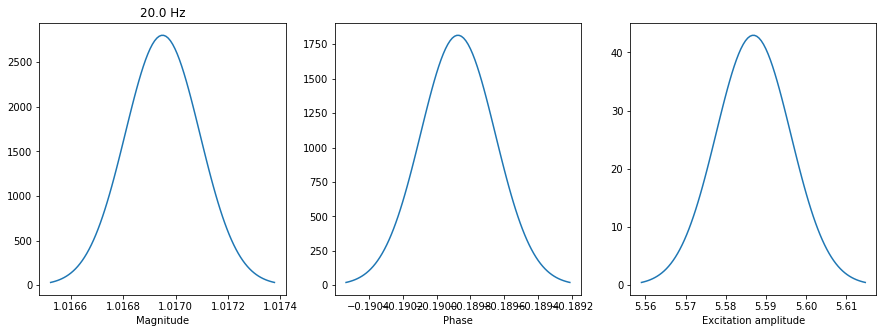

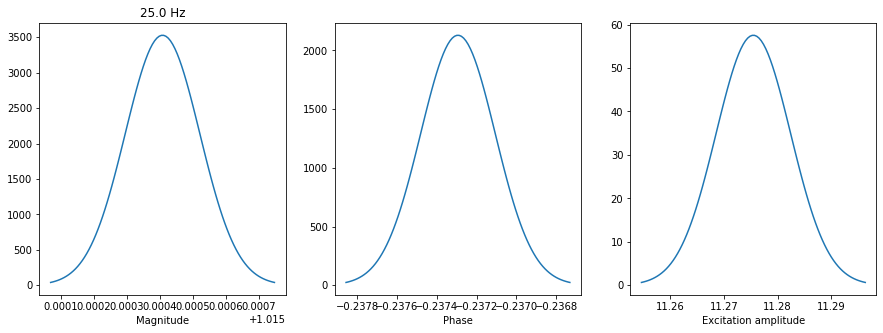

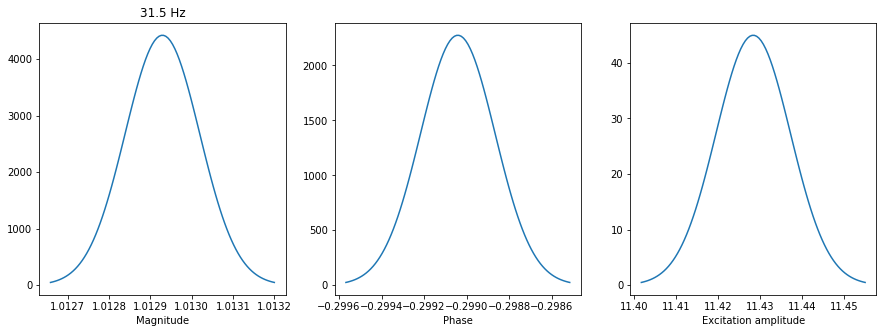

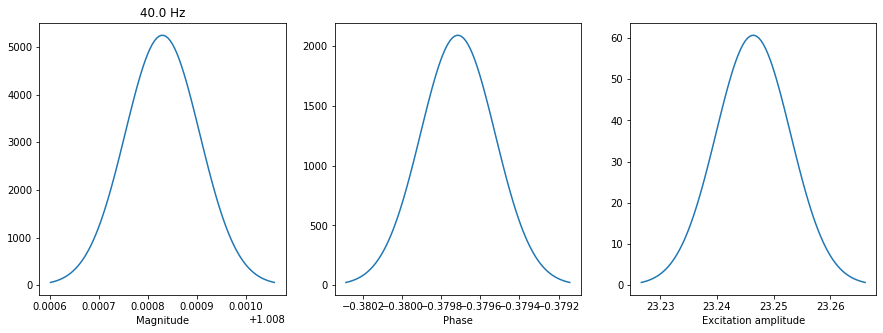

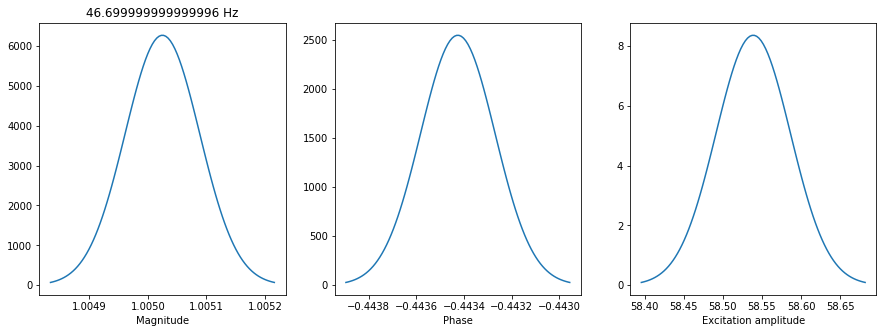

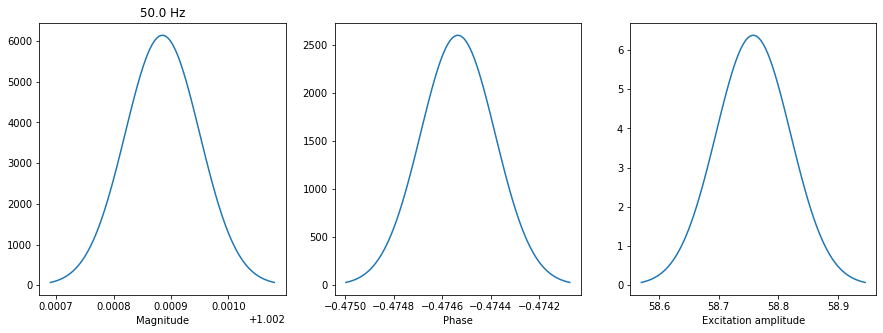

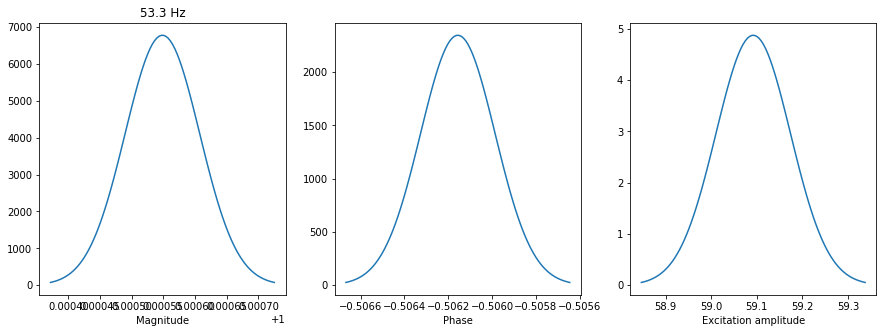

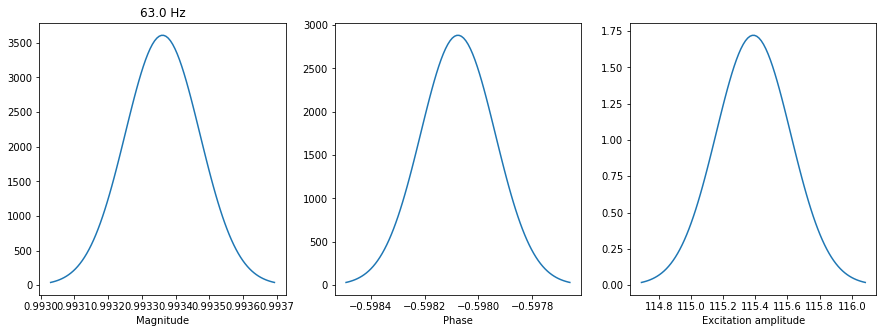

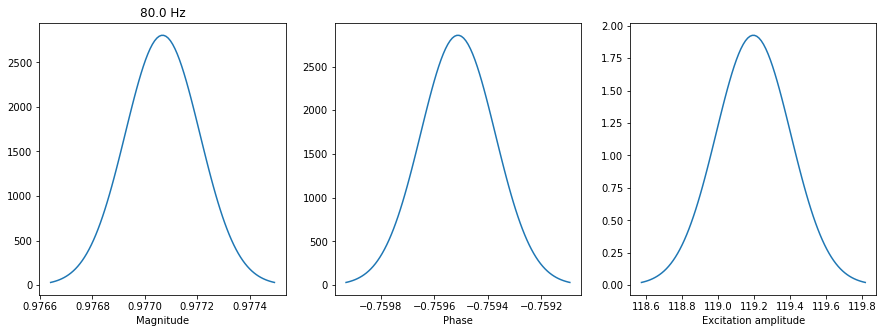

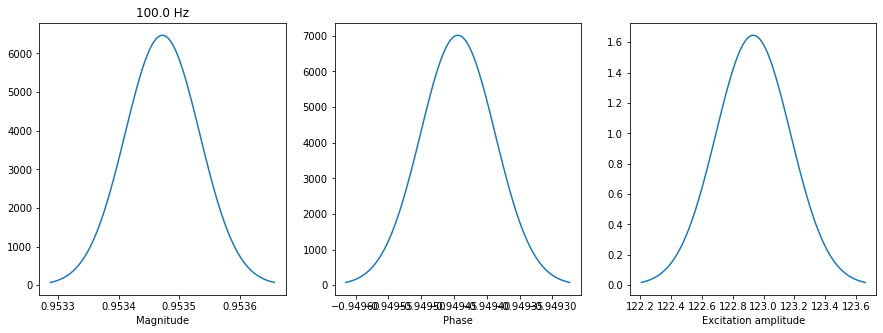

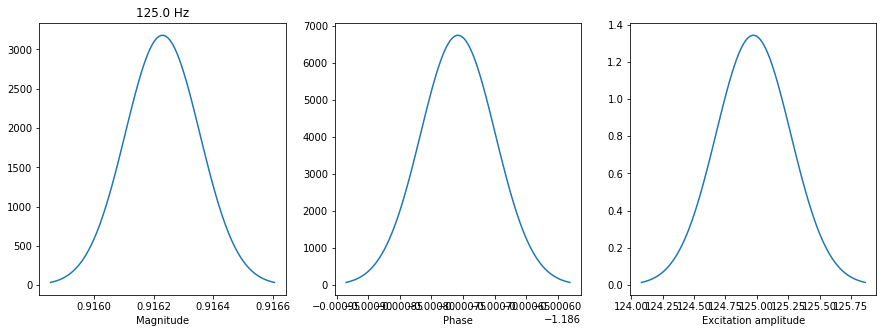

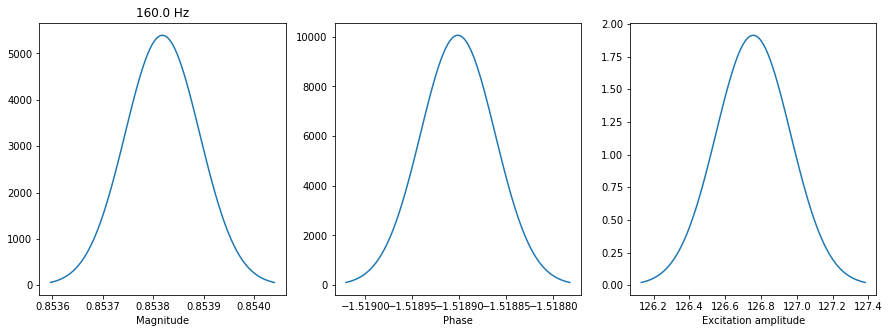

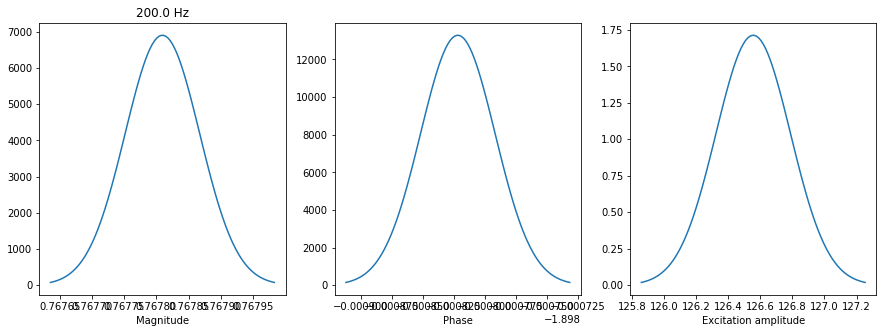

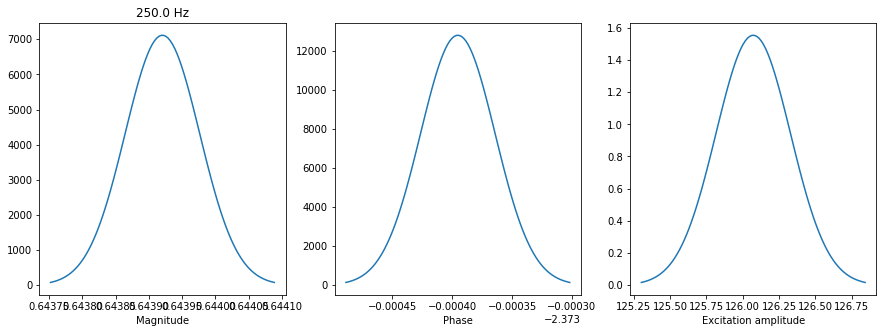

In [46]:
normal_distribution(avg_std_PTB)

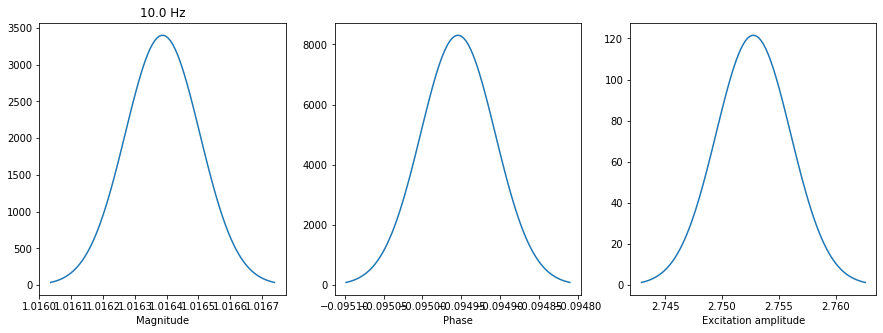

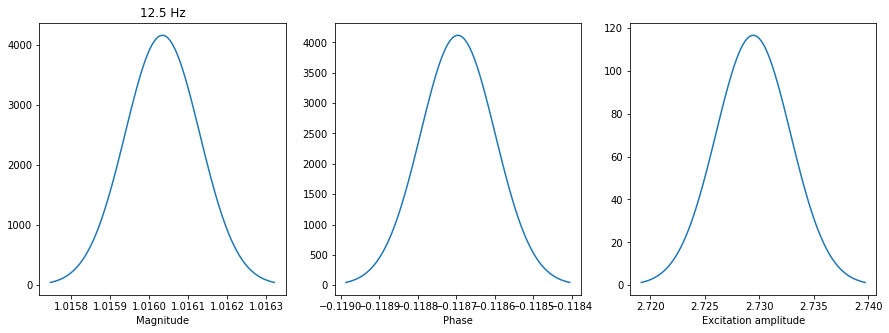

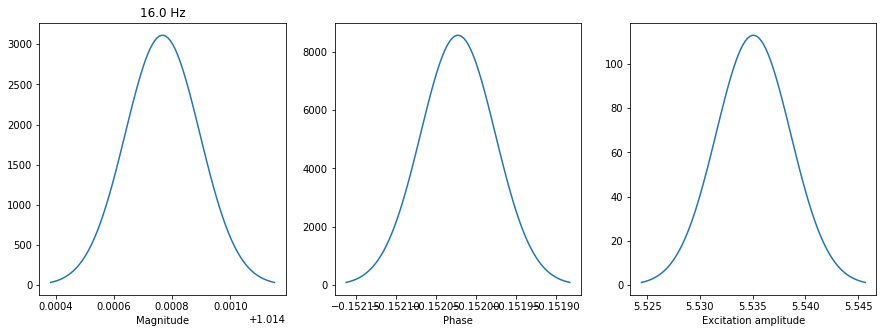

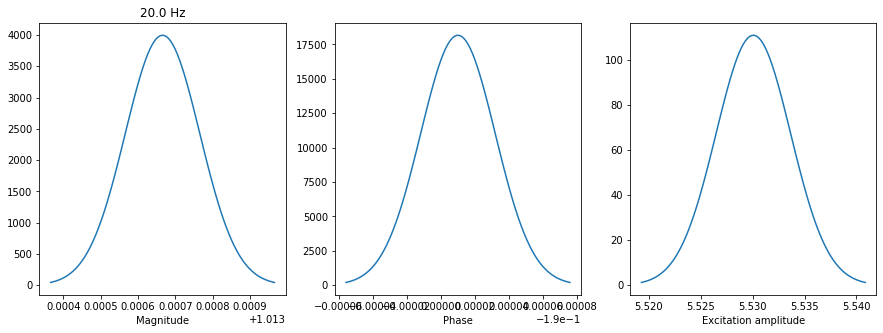

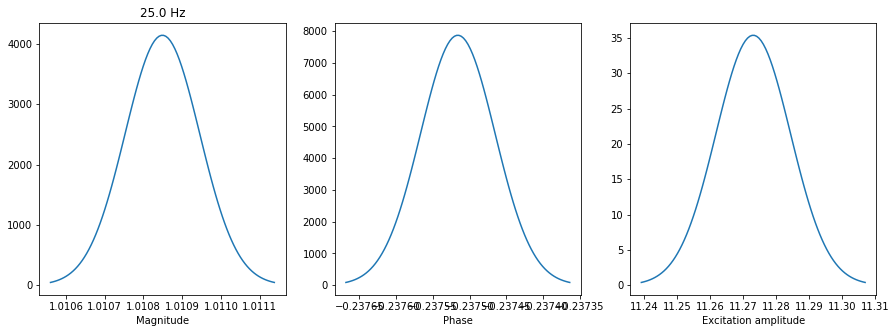

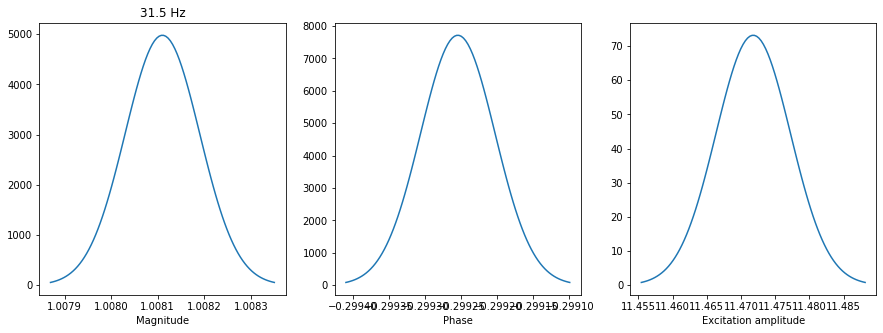

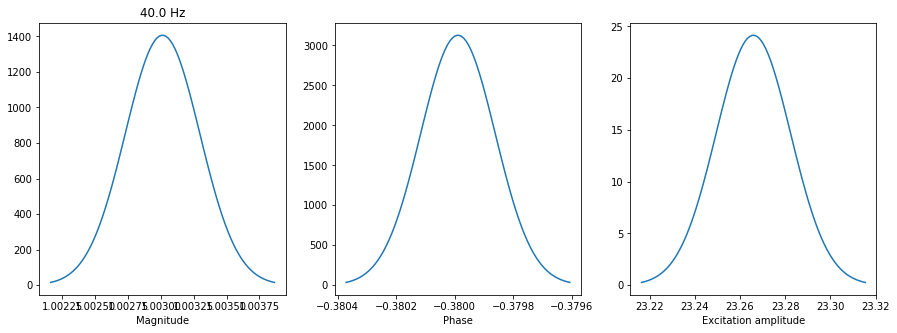

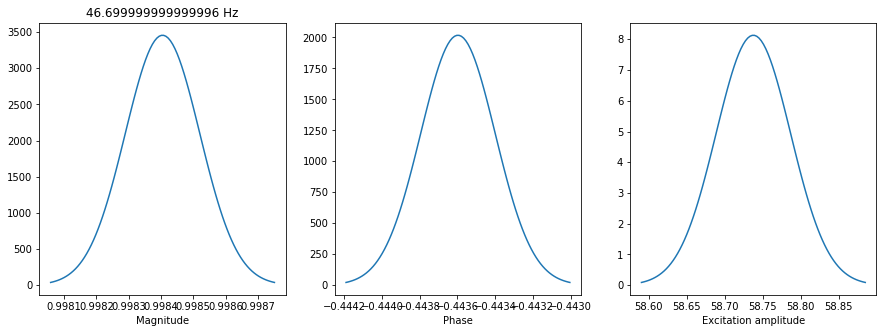

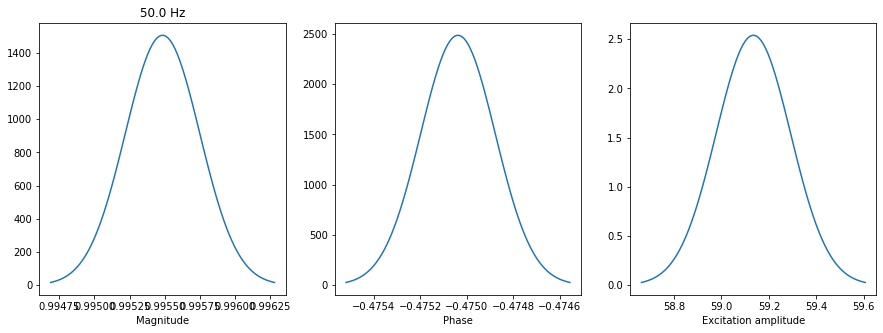

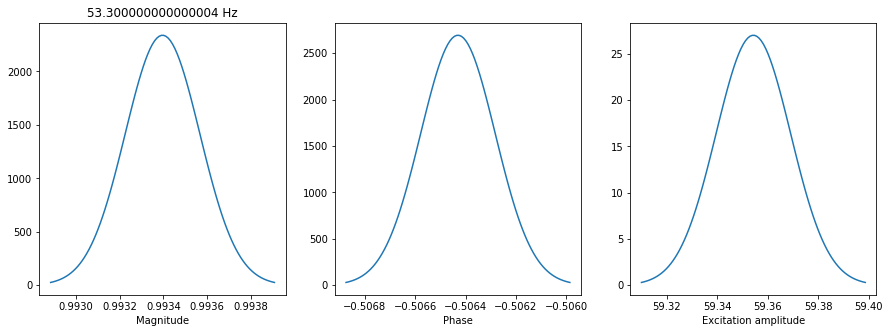

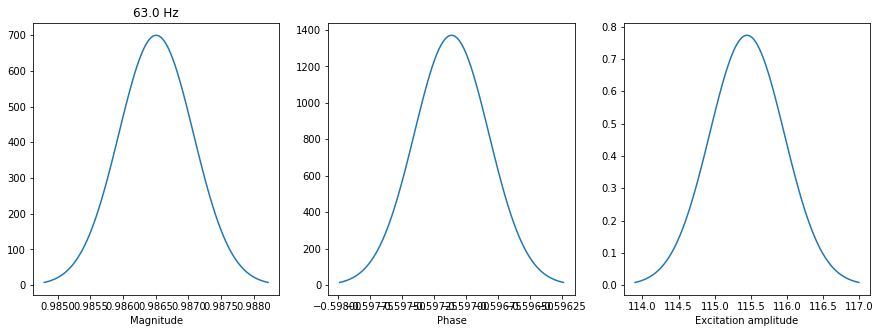

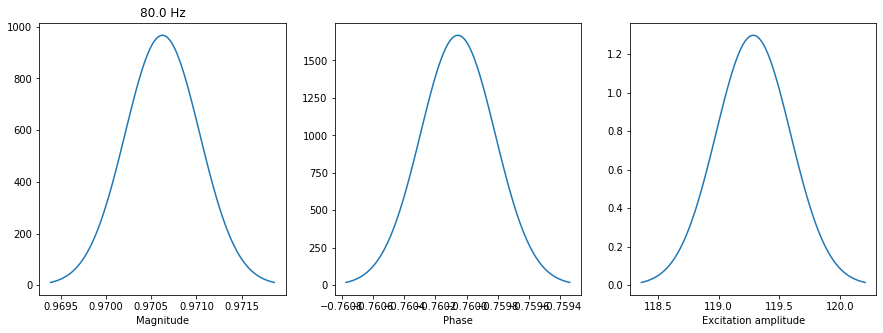

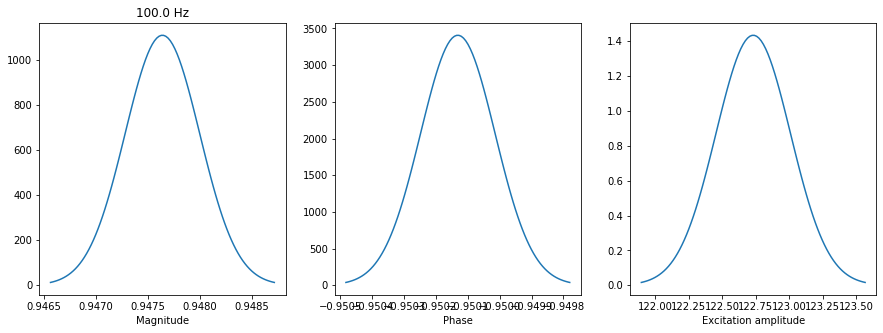

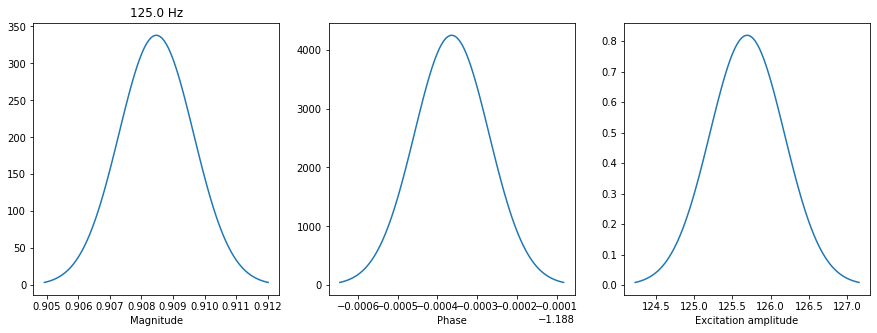

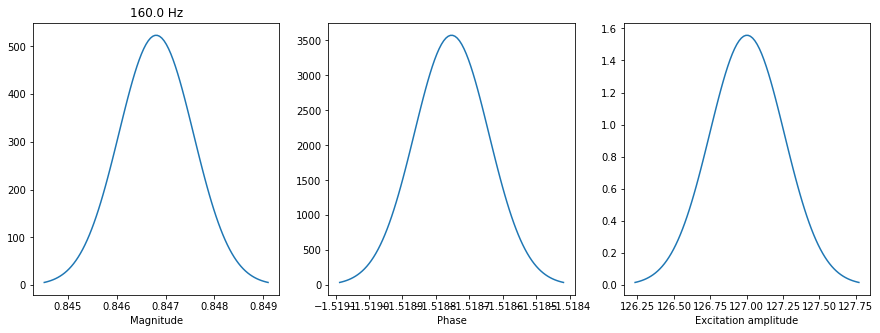

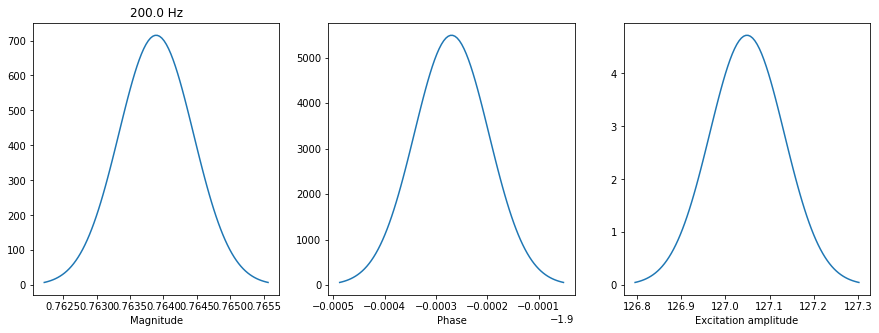

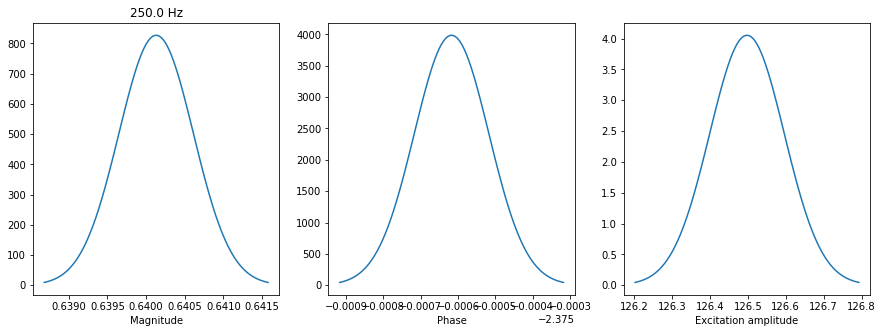

In [47]:
normal_distribution(avg_std_CEM)

## 5.2 En values

It is not clear if the uncertainties have been provided as expanded or standard uncertainties. Because of this, a condition has been given in the following function. The En values for Magnitude, Phase and Excitation amplitude have been calculated according to formula on the figure:

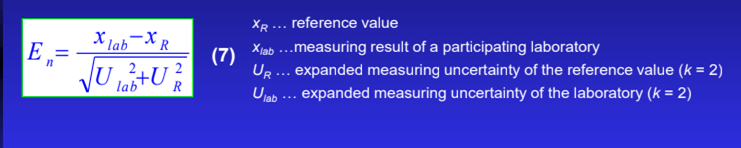

<br>$x_{lab}$ corresponds to the mean value at a specific frequency for the participating laboratory and
<br>$x_{ref}$ corresponds to the mean value at a specific frequency for the reference laboratory 
<br>$U_{lab}$ corresponds to the expanded measurement uncertainty of the mean value at a specific frequency for the participating laboratory 
<br>$U_{ref}$ corresponds to the expanded measurement uncertainty of the mean value at a specific frequency for the reference laboratory 
<br>If:<br> |En|<=,1 - the criteria is satisfied<br>|En|>1 - the criteria is not satisfied.
<br>One of the laboratories has been selected as a reference laboratory and other as a participating laboratory.This sequence is not important because it affects only the sign. That is why an absolute values are taken into account. 

In [48]:
#1
def calculate_En_values(df1,df2,condition,names):
    En_values=np.empty((len(df1),3))

    if condition=="not expanded uncertainty":
        En_values[:,0]=np.abs(((df1[names[1]]-df2[names[1]])/(2*(np.sqrt(df1[names[9]]**2 +df2[names[9]]**2)))))
        En_values[:,1]=np.abs(((df1[names[3]]-df2[names[3]])/(2*(np.sqrt(df1[names[11]]**2 +df2[names[11]]**2)))))
        En_values[:,2]=np.abs(((df1[names[6]]-df2[names[6]])/(2*(np.sqrt(df1[names[14]]**2 +df2[names[14]]**2))))) 
        #if averaged values of uncertainties:
        #En_values[:,0]=np.abs(((df1[names[1]]-df2[names[1]])/(2*(np.sqrt(df1[names[2]]**2 +df2[names[2]]**2)))))
        #En_values[:,1]=np.abs(((df1[names[3]]-df2[names[3]])/(2*(np.sqrt(df1[names[4]]**2 +df2[names[4]]**2)))))
        #En_values[:,2]=np.abs(((df1[names[6]]-df2[names[6]])/(2*(np.sqrt(df1[names[7]]**2 +df2[names[7]]**2))))) 
    elif condition=="expanded uncertainty":
        En_values[:,0]=np.abs(((df1[names[1]]-df2[names[1]])/(np.sqrt(df1[names[9]]**2 +df2[names[9]]**2))))
        En_values[:,1]=np.abs(((df1[names[3]]-df2[names[3]])/(np.sqrt(df1[names[11]]**2 +df2[names[11]]**2))))
        En_values[:,2]=np.abs(((df1[names[6]]-df2[names[6]])/(np.sqrt(df1[names[14]]**2 +df2[names[14]]**2)))) 
        #En_values[:,0]=np.abs(((df1[names[1]]-df2[names[1]])/(np.sqrt(df1[names[2]]**2 +df2[names[2]]**2))))
        #En_values[:,1]=np.abs(((df1[names[3]]-df2[names[3]])/(np.sqrt(df1[names[4]]**2 +df2[names[4]]**2))))
        #En_values[:,2]=np.abs(((df1[names[6]]-df2[names[6]])/(np.sqrt(df1[names[7]]**2 +df2[names[7]]**2)))) 
    else:
        pass
    return En_values 

In [49]:
En_values_notexp=calculate_En_values(avg_std_PTB,avg_std_CEM,"not expanded uncertainty",avg_std_PTB.columns)
En_values_exp=calculate_En_values(avg_std_PTB,avg_std_CEM,"expanded uncertainty",avg_std_PTB.columns)

In [50]:
En_values_notexp_df=pd.DataFrame(En_values_notexp, columns=["Magnitude","Phase","Excitation amplitude"])
En_values_exp_df=pd.DataFrame(En_values_exp, columns=["Magnitude","Phase","Excitation amplitude"])

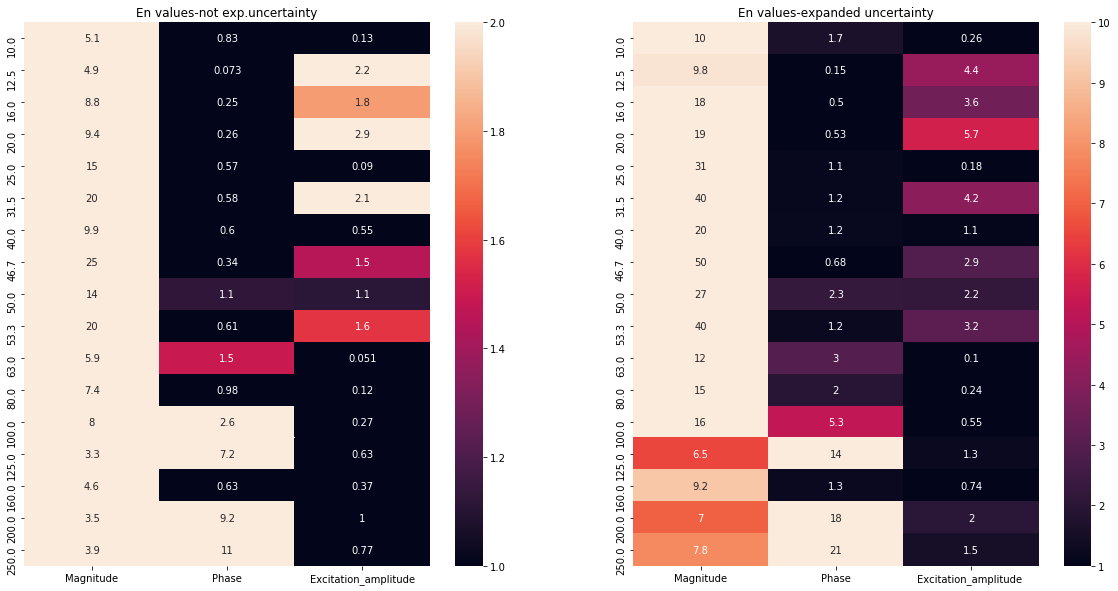

In [51]:

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.heatmap(En_values_notexp_df, vmax=2, vmin=1,annot=True,yticklabels=PTB_separated_by_freq.keys(),xticklabels=["Magnitude","Phase","Excitation_amplitude"] )
plt.title("En values-not exp.uncertainty")

plt.subplot(1,2,2)
plt.title("En values-expanded uncertainty")
sns.heatmap(En_values_exp_df, vmax=10, vmin=1,annot=True,yticklabels=PTB_separated_by_freq.keys(),xticklabels=["Magnitude","Phase","Excitation_amplitude "] )
plt.show()

# 6. Case study 2: Calculate En values for estimated weighted values

For the weighted mean of a list of data for which each element ${\ x_{i}}$ potentially comes from a different probability distribution with known variance ${\sigma _{i}^{2}}$, one possible choice for the weights is given by the reciprocal of variance [2]:

$$w_{i}={\frac {1}{\sigma _{i}^{2}}}$$

The weighted mean in this case is:

$${\bar {x}}={\frac {\sum _{i=1}^{n}\left({\dfrac {x_{i}}{\sigma _{i}^{2}}}\right)}{\sum _{i=1}^{n}{\dfrac {1}{\sigma _{i}^{2}}}}}$$,

and the standard error of the weighted mean (with variance weights) is:

$$\sigma _{\bar {x}}={\sqrt {\frac {1}{\sum _{i=1}^{n}\sigma _{i}^{-2}}}}$$

Additionally, an effective sample size (ESS) [3] has been calculated at each frequency and for each quantity as:

$$ ESS=\frac {{(\sum _{i=1}^{n} w_{i}})^{2}}{\sum _{i=1}^{n} w_{i}^{2}}$$

## 6.1 Weighted values

In [52]:
def calculate_weighted_values(dictionary,names):
    
    weighted_val=np.empty((len(dictionary.keys()),6))
    effective_sample_size=np.empty((len(dictionary.keys()),3))
    
    for val,i in zip(dictionary.values(),range(len(dictionary.keys()))):
        weighted_val[i,0]=np.sum(val[names[1]].values*(1./val[names[2]].values**2))/np.sum(1./val[names[2]].values**2)
        weighted_val[i,1]=1./np.sqrt(np.sum(1./val[names[2]].values**2))
        effective_sample_size[i,0]=((np.sum(1./val[names[2]].values**2))**2)/np.sum(1./val[names[2]].values**4)
        
        
        weighted_val[i,2]=np.sum(val[names[3]].values*(1./val[names[4]].values**2))/np.sum(1./val[names[4]].values**2)
        weighted_val[i,3]=1./np.sqrt(np.sum(1./val[names[4]].values**2))
        effective_sample_size[i,1]=((np.sum(1./val[names[4]].values**2))**2)/np.sum(1./val[names[4]].values**4)
                     
        weighted_val[i,4]=np.sum(val[names[6]].values*(1./val[names[7]].values**2))/np.sum(1./val[names[7]].values**2)
        weighted_val[i,5]=1./np.sqrt(np.sum(1./val[names[7]].values**2))
        effective_sample_size[i,2]=((np.sum(1./val[names[7]].values**2))**2)/np.sum(1./val[names[7]].values**4)
                     
    return weighted_val,effective_sample_size

In [53]:
weighted_values_PTB,effective_sample_size_PTB=calculate_weighted_values(PTB_separated_by_freq,q_names)
weighted_values_CEM,effective_sample_size_CEM=calculate_weighted_values(CEM_separated_by_freq_new,q_names)

column_names_list1  =[name for name in q_names if name != 'Frequency [Hz]' and name!='Excitation_freq [Hz]']

weighted_values_PTB=pd.DataFrame(weighted_values_PTB, columns=column_names_list1)
weighted_values_CEM=pd.DataFrame(weighted_values_CEM, columns=column_names_list1)

In [54]:
effective_sample_size_PTB[:1,:] #@ 10 Hz for magnitude, phase and excitation amplitude

array([[9.99995198, 7.5590438 , 9.99984263]])

In [55]:
effective_sample_size_CEM[:1,:] #@ 10 Hz for magnitude, phase and excitation amplitude

array([[8.99999918, 8.99999967, 8.99994904]])

## 6.2 En values for weighted data

In [56]:
def calculate_En_values_weighted(df1,df2,condition,names):
    En_values=np.empty((df1.shape[0],3))
    
    for i in range (df1.shape[0]):
        if condition=="not expandend uncertainty":
            En_values[:,0]=np.abs(((df1[names[1]].values-df2[names[1]].values)/(2*(np.sqrt(df1[names[2]].values**2 +df2[names[2]].values**2)))))
            En_values[:,1]=np.abs(((df1[names[3]].values-df2[names[3]].values)/(2*(np.sqrt(df1[names[4]].values**2 +df2[names[4]].values**2)))))
            En_values[:,2]=np.abs(((df1[names[6]].values-df2[names[6]].values)/(2*(np.sqrt(df1[names[7]].values**2 +df2[names[7]].values**2))))) 
          
        elif condition=="expanded uncertainty":
            En_values[:,0]=np.abs(((df1[names[1]]-df2[names[1]])/(np.sqrt(df1[names[2]]**2 +df2[names[2]]**2))))
            En_values[:,1]=np.abs(((df1[names[3]]-df2[names[3]])/(np.sqrt(df1[names[4]]**2 +df2[names[4]]**2))))
            En_values[:,2]=np.abs(((df1[names[6]]-df2[names[6]])/(np.sqrt(df1[names[7]]**2 +df2[names[7]]**2)))) 
        else:
            pass
    return En_values  

In [57]:
weighted_values_PTB.head(2)

Magnitude [m s^-2/m s^-2 ]  Uncertainty [m s^-2/m s^-2 ]  Phase [°]  \
0                    1.019031                      0.000065  -0.094730   
1                    1.018366                      0.000065  -0.118499   

   Uncertainty[°]  Excitation_amplitude [m s^-2]  \
0        0.000230                       2.751078   
1        0.000448                       2.755883   

   Excitation_amplitude_uncert [m s^-2]  
0                              0.000174  
1                              0.000174

In [58]:
En_values_weighted_notexp=calculate_En_values_weighted(weighted_values_PTB,weighted_values_CEM,"not expandend uncertainty",q_names)
En_values_weighted_exp=calculate_En_values_weighted(weighted_values_PTB,weighted_values_CEM,"expanded uncertainty",q_names)

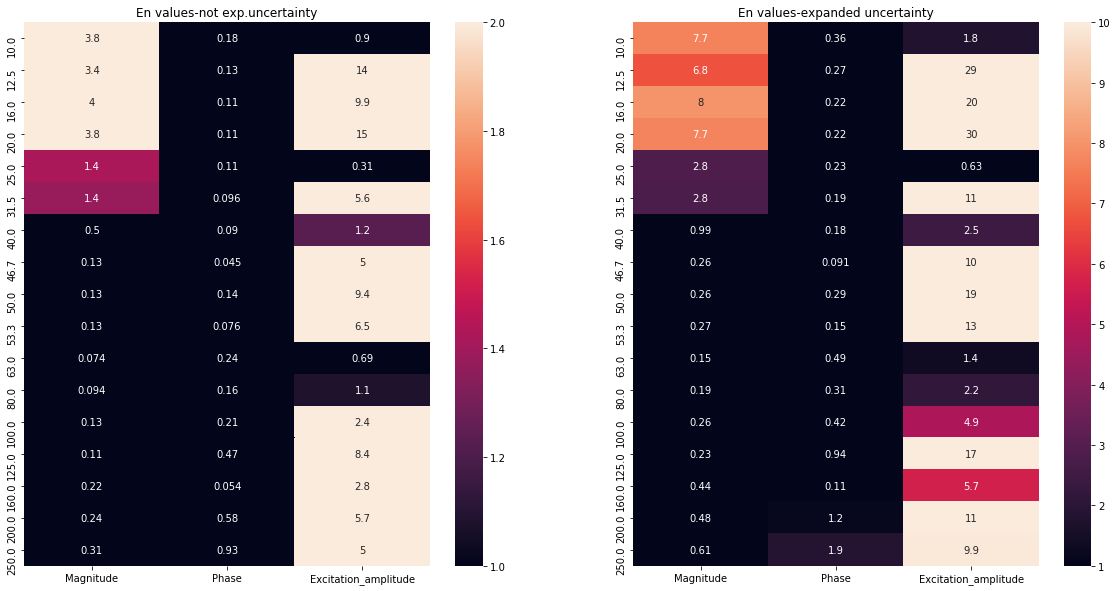

In [59]:

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.heatmap(En_values_weighted_notexp, vmax=2, vmin=1,annot=True,yticklabels=PTB_separated_by_freq.keys(),xticklabels=["Magnitude","Phase","Excitation_amplitude"] )
plt.title("En values-not exp.uncertainty")

plt.subplot(1,2,2)
plt.title("En values-expanded uncertainty")
sns.heatmap(En_values_weighted_exp, vmax=10, vmin=1,annot=True,yticklabels=PTB_separated_by_freq.keys(),xticklabels=["Magnitude","Phase","Excitation_amplitude"] )
plt.show()

## 6.3 F-test

A Statistical F Test uses an F Statistic to compare two variances, s1 and s2, by dividing them. The result is always a positive number (because variances are always positive). The equation for comparing two variances with the F-test is:

$$ F = \frac {{s_{1}}^{2}}{{s_{2}}^{2}}$$

The population variances are equal when running an F Test. Therefore, the null hypothesis will always be that the variances are equal.

<br>The null hypothesis H0: ${s_{1}}^{2} = {s_{2}}^{2}$
<br>The research hypothesis H1: ${s_{1}}^{2} != {s_{2}}^{2}$,

where s1 and s2 correspond to the weighted standard deviations calulated for each quantity (Magnitude, Phase and Excitation amplitude) at each frequency.

<br>Several assumptions are made for the test: 
<br>1) The population must be approximately normally distributed (i.e. fit the shape of a bell curve) in order to use the test. 
<br>2) The samples must be independent events. 
<br>3) The larger variance should always go in the numerator to force the test into a right-tailed test. Right-tailed tests are easier to calculate.
For this two-tailed test, the level of significance, $\alpha$ = 5% is divided  by 2 before finding the right critical value.
Degrees of freedom are ESS-1 for both laboratories.

The calculated F-value is then compared to the critical F value. If F>Fcrit, and, additionally, p-value>$\alpha$, the null hypothesis can be rejected.

In [60]:
Fval=np.empty((weighted_values_PTB.shape[0],3))
differences=np.empty((weighted_values_PTB.shape[0],3))
differences[:,0]=weighted_values_CEM[q_names[2]]**2-weighted_values_PTB[q_names[2]]**2
differences[:,1]=weighted_values_CEM[q_names[4]]**2-weighted_values_PTB[q_names[4]]**2
differences[:,2]=weighted_values_CEM[q_names[7]]**2-weighted_values_PTB[q_names[7]]**2
print (differences[:3]) # some st. deviations in phase are higher for PTB - it shall go to numerator

[[ 1.10644078e-07  2.86367451e-07  8.11691794e-07]
 [ 1.10539757e-07  1.37871144e-07  7.97388753e-07]
 [ 1.43619828e-07 -3.84211528e-08  3.27991475e-06]]


In [61]:
Fval[:,0]= (weighted_values_CEM[q_names[2]].values**2)/(weighted_values_PTB[q_names[2]].values**2)

Fval[:1,1]=(weighted_values_CEM[q_names[4]].values[:1]**2)/(weighted_values_PTB[q_names[4]].values[:1]**2)
Fval[2:7,1]=(weighted_values_PTB[q_names[4]].values[2:7]**2)/(weighted_values_CEM[q_names[4]].values[2:7]**2)
Fval[7:,1]=(weighted_values_CEM[q_names[4]].values[7:]**2)/(weighted_values_PTB[q_names[4]].values[7:]**2)

Fval[:,2]= (weighted_values_CEM[q_names[7]].values)**2/(weighted_values_PTB[q_names[7]].values**2)

In [62]:
p_val=np.empty((Fval.shape))
Fcrit=np.empty((Fval.shape))

Fcrit[:,0]=scipy.stats.f.ppf(q=1-0.025, dfn=effective_sample_size_CEM[:,0]-1, dfd=effective_sample_size_PTB[:,0]-1)
p_val[:,0]=scipy.stats.f.sf(Fval[:,0],effective_sample_size_CEM[:,0]-1,effective_sample_size_PTB[:,0]-1)

Fcrit[:1,1]=scipy.stats.f.ppf(q=1-0.025, dfn=effective_sample_size_CEM[:1,1]-1, dfd=effective_sample_size_PTB[:1,1]-1)
p_val[:1,1]=scipy.stats.f.sf(Fval[:1,1],effective_sample_size_CEM[:1,1]-1,effective_sample_size_PTB[:1,1]-1)

Fcrit[2:7,1]=scipy.stats.f.ppf(q=1-0.025, dfn=effective_sample_size_PTB[2:7,1]-1, dfd=effective_sample_size_CEM[2:7,1]-1)
p_val[2:7,1]=scipy.stats.f.sf(Fval[2:7,1],effective_sample_size_PTB[2:7,1]-1,effective_sample_size_CEM[2:7,1]-1)

Fcrit[7:,1]=scipy.stats.f.ppf(q=1-0.025, dfn=effective_sample_size_CEM[7:,1]-1, dfd=effective_sample_size_PTB[7:,1]-1)
p_val[7:,1]=scipy.stats.f.sf(Fval[7:,1],effective_sample_size_CEM[7:,1]-1,effective_sample_size_PTB[7:,1]-1)

Fcrit[:,2]=scipy.stats.f.ppf(q=1-0.025, dfn=effective_sample_size_CEM[:,2]-1, dfd=effective_sample_size_PTB[:,2]-1)
p_val[:,2]=scipy.stats.f.sf(Fval[:,2],effective_sample_size_CEM[:,2]-1,effective_sample_size_PTB[:,2]-1)

In [63]:
Fcrit[:3]

array([[4.10196936e+000, 5.17034706e+000, 4.10200456e+000],
       [4.10198934e+000, 2.39127773e-321, 4.10199443e+000],
       [4.11680123e+000, 4.60512370e+000, 4.10199107e+000]])

In [64]:
Fval[:3]

array([[27.58796187,  6.39793663, 27.81152237],
       [27.53357331,  1.5       , 27.24968706],
       [35.36590943,  1.1130957 , 27.41086462]])

In [65]:
p_val[:3]

array([[1.89077037e-005, 1.43806734e-002, 1.82751316e-005],
       [1.90673621e-005, 2.39127773e-321, 1.99213222e-005],
       [6.72818843e-006, 4.33584330e-001, 1.94308796e-005]])

In [66]:
F_differences=pd.DataFrame(Fval-Fcrit,columns=['Magnitude', "Phase","Excitation Amplitude"])
p_differences=pd.DataFrame(p_val-0.05,columns=['Magnitude', "Phase","Excitation Amplitude"])

In [67]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s > 0
    return ['background-color: yellow' if v else '' for v in is_max]

In [68]:
F_differences.style.apply(highlight_max) #Fval-Fcrit>0 - reject the null hypothesis. 

In [69]:
F_differences.style.bar(subset=['Magnitude', "Phase","Excitation Amplitude"], color='#d65f5f')

In [70]:
p_val=pd.DataFrame(p_val,columns=['Magnitude', "Phase","Excitation Amplitude"])
p_val.style.applymap(lambda x: 'background-color : red' if x<0.05 else 'background-color : green')


# 7. Case study 3: Calculate En values for Monte Carlo method

## 7.1 Best estimates and standard uncertainties


In [71]:
def MC(dictionary, names):
    keys =list(dictionary.keys())
    sample_size=1000
    dict_val=list(dictionary.values())

    MC_RESULTS=np.empty((len(dictionary.values()),6))

    p=0.05
    q=p*sample_size
    r= (sample_size-q)/2
    q = p*sample_size
    x_low=np.empty(len(dictionary.values()))
    x_high=np.empty(len(dictionary.values()))

    y_low=np.empty(len(dictionary.values()))
    y_high=np.empty(len(dictionary.values()))

    z_low=np.empty(len(dictionary.values()))
    z_high=np.empty(len(dictionary.values()))
    for val, val_in_list in zip(dictionary.values(), range(len(dict_val))):
            X_var=np.empty((len(dictionary.values()),val.shape[0],sample_size))
            Y_var=np.empty((len(dictionary.values()),val.shape[0],sample_size))
            Z_var=np.empty((len(dictionary.values()),val.shape[0],sample_size))
            for item in range(len(val)): #ispraviti
                X_var[val_in_list,item,:]=(np.random.normal(loc=val["Magnitude [m s^-2/m s^-2 ]"].values[item], scale=val["Uncertainty [m s^-2/m s^-2 ]"].values[item], size=1000))
                Y_var[val_in_list,item,:]=(np.random.normal(loc=val["Phase [°]"].values[item], scale=val["Uncertainty[°]"].values[item], size=1000))
                Z_var[val_in_list,item,:]=(np.random.normal(loc=val["Excitation_amplitude [m s^-2]"].values[item], scale=val["Excitation_amplitude_uncert [m s^-2]"].values[item], size=1000))
            x=X_var[val_in_list].mean(axis=0)
            y=Y_var[val_in_list].mean(axis=0)
            z=Z_var[val_in_list].mean(axis=0)
            x_low[val_in_list]=x[int(r)]
            x_high[val_in_list]=x[int(r+q)]
            y_low[val_in_list]=y[int(r)]
            y_high[val_in_list]=y[int(r+q)]
            z_low[val_in_list]=z[int(r)]
            z_high[val_in_list]=z[int(r+q)]

            MC_RESULTS[val_in_list,0]=x.mean()
            MC_RESULTS[val_in_list,1]=np.sqrt((np.sum((x-x.mean())**2)/(sample_size-1)))
            MC_RESULTS[val_in_list,2]=y.mean()
            MC_RESULTS[val_in_list,3]=np.sqrt((np.sum((y-y.mean())**2)/(sample_size-1)))
            MC_RESULTS[val_in_list,4]=z.mean()
            MC_RESULTS[val_in_list,5]=np.sqrt((np.sum((z-z.mean())**2)/(sample_size-1)))
    MC_RESULTS=pd.DataFrame(MC_RESULTS, columns=names)

    return MC_RESULTS
    

In [72]:
column_names_list1  =[name for name in q_names if name != 'Frequency [Hz]' and name!='Excitation_freq [Hz]']
MC_values_PTB=MC(PTB_separated_by_freq,column_names_list1)
MC_values_CEM=MC(CEM_separated_by_freq_new,column_names_list1)

In [73]:
MC_values_PTB.head(2)

Magnitude [m s^-2/m s^-2 ]  Uncertainty [m s^-2/m s^-2 ]  Phase [°]  \
0                    1.019031                      0.000066  -0.094675   
1                    1.018366                      0.000066  -0.118645   

   Uncertainty[°]  Excitation_amplitude [m s^-2]  \
0        0.000275                       2.751104   
1        0.000548                       2.755900   

   Excitation_amplitude_uncert [m s^-2]  
0                              0.000175  
1                              0.000181

In [74]:
MC_values_CEM.head(2)

Magnitude [m s^-2/m s^-2 ]  Uncertainty [m s^-2/m s^-2 ]  Phase [°]  \
0                    1.016410                      0.000344  -0.094973   
1                    1.016019                      0.000324  -0.118709   

   Uncertainty[°]  Excitation_amplitude [m s^-2]  \
0        0.000581                       2.752769   
1        0.000594                       2.729436   

   Excitation_amplitude_uncert [m s^-2]  
0                              0.000938  
1                              0.000924

In [75]:
En_values_MC_notexp=calculate_En_values_weighted(MC_values_PTB,MC_values_CEM,"not expandend uncertainty",q_names)


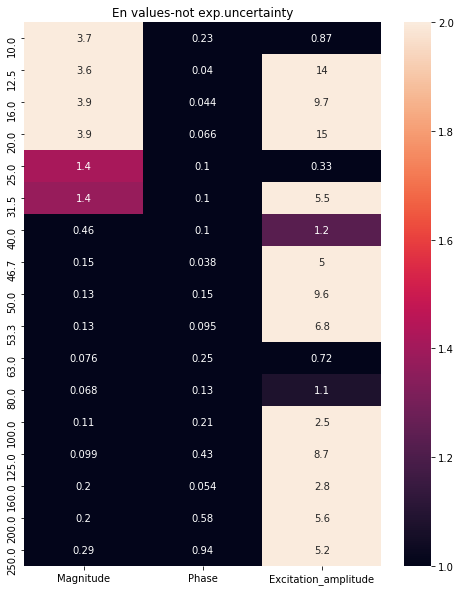

In [76]:
plt.figure(figsize=(8,10))
sns.heatmap(En_values_MC_notexp, vmax=2, vmin=1,annot=True,yticklabels=PTB_separated_by_freq.keys(),xticklabels=["Magnitude","Phase","Excitation_amplitude"] )
plt.title("En values-not exp.uncertainty")
plt.show()

# 8. Datasets for the Excel validation

In [77]:
#this is for analysis in Excel
def sort_values(dataset):
    dataset=dataset.sort_values("Frequency [Hz]", ascending=True)
    return dataset

In [78]:
whole_dataset_PTB=sort_values(whole_dataset_PTB)
whole_dataset_CEM=sort_values(whole_dataset_CEM)

In [79]:
whole_dataset_PTB.head(2)

Frequency [Hz]  Magnitude [m s^-2/m s^-2 ]  Uncertainty [m s^-2/m s^-2 ]  \
0             10.0                    1.019327                      0.000204   
51            10.0                    1.018666                      0.000204   

    Phase [°]  Uncertainty[°]  Excitation_freq [Hz]  \
0   -0.094938        0.000540                  10.0   
51  -0.094446        0.000998                  10.0   

    Excitation_amplitude [m s^-2]  Excitation_amplitude_uncert [m s^-2]  
0                           2.739                              0.000548  
51                          2.749                              0.000550

In [80]:
whole_dataset_CEM.head(2)

Frequency [Hz]  Magnitude [m s^-2/m s^-2 ]  Uncertainty [m s^-2/m s^-2 ]  \
78             10.0                    1.016497                      0.001017   
135            10.0                    1.016513                      0.001017   

     Phase [°]  Uncertainty[°]  Excitation_freq [Hz]  \
78   -0.094915        0.001748                  10.0   
135  -0.094927        0.001747                  10.0   

     Excitation_amplitude [m s^-2]  Excitation_amplitude_uncert [m s^-2]  
78                          2.7526                              0.002753  
135                         2.7605                              0.002760

In [81]:
writer2 = pd.ExcelWriter('All_datasets.xlsx')

whole_dataset_CEM.to_excel(writer2, sheet_name = 'CEM', index = False)
whole_dataset_PTB.to_excel(writer2, sheet_name = 'PTB', index = False)

writer2.save()

# References

[1] https://www.investopedia.com/terms/c/coefficientofvariation.asp
<br>[2] https://en.wikipedia.org/wiki/Weighted_arithmetic_mean
<br>[3] https://en.wikipedia.org/wiki/Effective_sample_size
<br>[4] https://online.stat.psu.edu/stat500/lesson/10/10.2/10.2.1
<br>[5] https://www.marsja.se/levenes-bartletts-test-of-equality-homogeneity-of-variance-in-python/